# Import necessary libraries

In [105]:
import os
import time
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from scipy.signal import wiener
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from skimage.metrics import structural_similarity
from scipy.linalg import sqrtm

# Important global variables

In [2]:
IMG_HEIGHT, IMG_WIDTH = (224, 224) # downscale the images so we can better observe the results
FILTER_HEIGHT, FILTER_WIDTH = (9, 9)
NUM_IMAGES = 160
EPOCHS = 3
BATCH_SIZE = 8
BUFFER_SIZE = 8

# Get SIDD images

In [3]:
normal_image_paths = []
noisy_image_paths = []

for dirpath, _, filenames in os.walk('/content/drive/MyDrive/Datasets/SII/SIDD_Small_sRGB_Only/Data', topdown=True):
    for image in filenames:
        if image.split('_')[0] == 'GT':
            normal_image_paths.append(dirpath + '/' + image)
        else:
            noisy_image_paths.append(dirpath + '/' + image)

len(normal_image_paths), len(noisy_image_paths), normal_image_paths, noisy_image_paths

(160,
 160,
 ['/content/drive/MyDrive/Datasets/SII/SIDD_Small_sRGB_Only/Data/0006_001_S6_00100_00060_4400_H/GT_SRGB_010.PNG',
  '/content/drive/MyDrive/Datasets/SII/SIDD_Small_sRGB_Only/Data/0010_001_S6_00800_00350_3200_N/GT_SRGB_010.PNG',
  '/content/drive/MyDrive/Datasets/SII/SIDD_Small_sRGB_Only/Data/0001_001_S6_00100_00060_3200_L/GT_SRGB_010.PNG',
  '/content/drive/MyDrive/Datasets/SII/SIDD_Small_sRGB_Only/Data/0007_001_S6_00100_00100_5500_L/GT_SRGB_010.PNG',
  '/content/drive/MyDrive/Datasets/SII/SIDD_Small_sRGB_Only/Data/0011_001_S6_00800_00500_5500_L/GT_SRGB_010.PNG',
  '/content/drive/MyDrive/Datasets/SII/SIDD_Small_sRGB_Only/Data/0008_001_S6_00100_00100_5500_N/GT_SRGB_010.PNG',
  '/content/drive/MyDrive/Datasets/SII/SIDD_Small_sRGB_Only/Data/0003_001_S6_00100_00060_3200_H/GT_SRGB_010.PNG',
  '/content/drive/MyDrive/Datasets/SII/SIDD_Small_sRGB_Only/Data/0002_001_S6_00100_00020_3200_N/GT_SRGB_010.PNG',
  '/content/drive/MyDrive/Datasets/SII/SIDD_Small_sRGB_Only/Data/0005_001_S6

In [18]:
# def load_and_process_image(filename, img_height, img_width):
#     # load the image
#     img = tf.keras.utils.load_img(filename,
#                                   color_mode='rgb',
#                                   target_size=(img_height, img_width),
#                                   interpolation='bilinear',
#                                   keep_aspect_ratio=False)
#     # turn image into tensor
#     img = tf.keras.utils.img_to_array(img)
#     return img

# def load_and_process_image(filename):
#     # read in the image
#     img = tf.io.read_file(filename)
#     # decode it into a tensor
#     img = tf.io.decode_png(img)
#     # # resize the image
#     # img = tf.image.resize(img,
#     #                       [img_height, img_width],
#     #                       method='bilinear',
#     #                       preserve_aspect_ratio=False)
#     return img

# normal_images = [load_and_process_image(path) for path in normal_image_paths[:NUM_IMAGES]]
# noisy_images = [load_and_process_image(path) for path in noisy_image_paths[:NUM_IMAGES]]

# normal_images, noisy_images

## Load images from directories and turn them into datasets

In [4]:
# create a dataset of file paths for normal images
normal_image_paths_ds = tf.data.Dataset.from_tensor_slices(normal_image_paths[:NUM_IMAGES])
# create a dataset of file paths for noisy images
noisy_image_paths_ds = tf.data.Dataset.from_tensor_slices(noisy_image_paths[:NUM_IMAGES])

def preprocess_dataset(ds):
    return ds.map(lambda x:
    tf.image.resize(tf.io.decode_png(tf.io.read_file(x)),
            [IMG_HEIGHT, IMG_WIDTH],
            method='bilinear',
            preserve_aspect_ratio=False))

normal_images = normal_image_paths_ds.apply(preprocess_dataset)
noisy_images = noisy_image_paths_ds.apply(preprocess_dataset)

normal_images, noisy_images

(<_MapDataset element_spec=TensorSpec(shape=(224, 224, None), dtype=tf.float32, name=None)>,
 <_MapDataset element_spec=TensorSpec(shape=(224, 224, None), dtype=tf.float32, name=None)>)

In [5]:
# batch, shuffle, and prefetch the normal and noisy data
train_dataset = normal_images.shuffle(buffer_size=BUFFER_SIZE).batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = noisy_images.shuffle(buffer_size=BUFFER_SIZE).batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset, test_dataset

(<_PrefetchDataset element_spec=TensorSpec(shape=(None, 224, 224, None), dtype=tf.float32, name=None)>,
 <_PrefetchDataset element_spec=TensorSpec(shape=(None, 224, 224, None), dtype=tf.float32, name=None)>)

# Define generator and discriminator architectures of the GAN

In [6]:
inputs = tf.keras.layers.Input(shape=(FILTER_HEIGHT, FILTER_WIDTH, 1))
outputs = tf.keras.layers.Conv2D(filters=32,
                        kernel_size=3,
                        kernel_initializer='random_normal',
                        strides=1,
                        padding='valid',
                        use_bias=False)(inputs)
# outputs = tf.keras.layers.BatchNormalization()(outputs)
outputs = tf.keras.layers.Conv2D(filters=16,
                        kernel_size=3,
                        kernel_initializer='random_normal',
                        strides=1,
                        padding='valid',
                        use_bias=False)(outputs)
# outputs = tf.keras.layers.BatchNormalization()(outputs)
outputs = tf.keras.layers.Conv2D(filters=1,
                        kernel_size=3,
                        kernel_initializer='random_normal',
                        strides=1,
                        padding='valid',
                        use_bias=False)(outputs)
# outputs = tf.keras.layers.BatchNormalization()(outputs)
outputs = tf.expand_dims(tf.squeeze(tf.abs(outputs), axis=-1), axis=1)

generator = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='generator')


In [7]:
inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
outputs = tf.keras.layers.Rescaling(1./255)(inputs)  # normalize the images to [0, 1]
outputs = tf.keras.layers.Conv2D(filters=64,
                        kernel_size=3,
                        strides=1,
                        padding='same',
                        activation='leaky_relu')(outputs)
outputs = tf.keras.layers.Conv2D(filters=128,
                        kernel_size=3,
                        strides=1,
                        padding='same',
                        activation='leaky_relu')(outputs)
outputs = tf.keras.layers.GlobalAveragePooling2D()(outputs)
outputs = tf.keras.layers.Dropout(rate=0.3)(outputs)
outputs = tf.keras.layers.Dense(512, activation="leaky_relu")(outputs)
outputs = tf.keras.layers.Dense(1, activation="tanh")(outputs)

discriminator = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='discriminator')

In [8]:
normal_sample = np.squeeze(np.array(list(normal_images.shuffle(buffer_size=BUFFER_SIZE, seed=42).take(count=1)), dtype=np.int32), axis=0)
noisy_sample = np.squeeze(np.array(list(noisy_images.shuffle(buffer_size=BUFFER_SIZE, seed=42).take(count=1)), dtype=np.int32), axis=0)
normal_sample.shape, noisy_sample.shape, normal_sample, noisy_sample

((224, 224, 3),
 (224, 224, 3),
 array([[[232, 207, 195],
         [218, 198, 186],
         [208, 192, 181],
         ...,
         [172, 160, 149],
         [188, 172, 159],
         [192, 172, 160]],
 
        [[230, 206, 191],
         [218, 199, 185],
         [217, 196, 187],
         ...,
         [182, 169, 155],
         [190, 170, 160],
         [198, 178, 160]],
 
        [[219, 199, 186],
         [213, 194, 178],
         [216, 197, 186],
         ...,
         [176, 163, 149],
         [197, 176, 161],
         [194, 174, 162]],
 
        ...,
 
        [[202, 191, 183],
         [190, 181, 182],
         [201, 185, 184],
         ...,
         [173, 160, 151],
         [180, 166, 154],
         [173, 162, 148]],
 
        [[207, 194, 184],
         [194, 182, 181],
         [187, 180, 177],
         ...,
         [179, 164, 154],
         [175, 162, 154],
         [170, 158, 150]],
 
        [[178, 168, 167],
         [185, 178, 177],
         [193, 179, 183],
         .

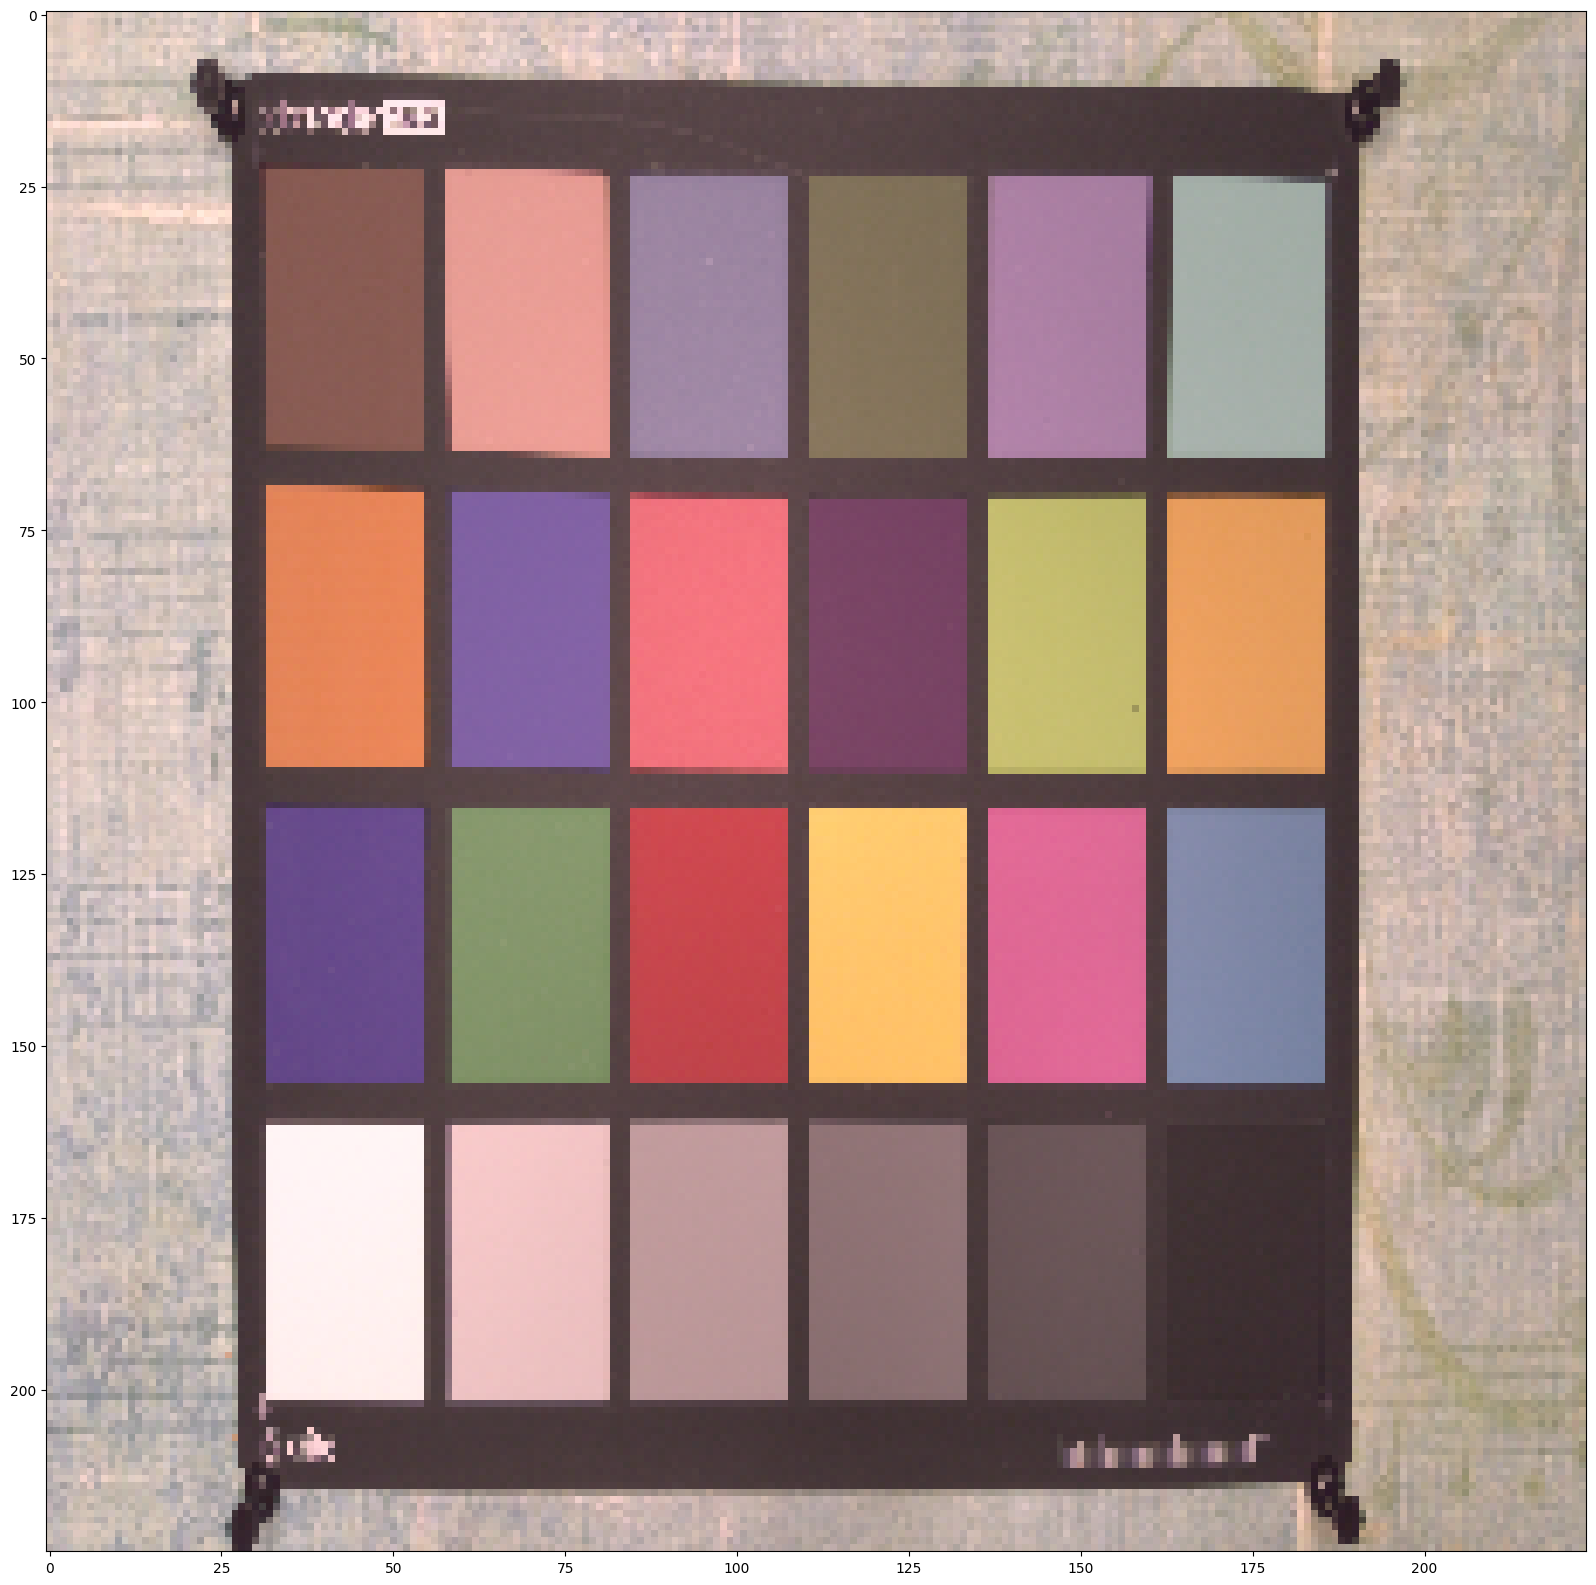

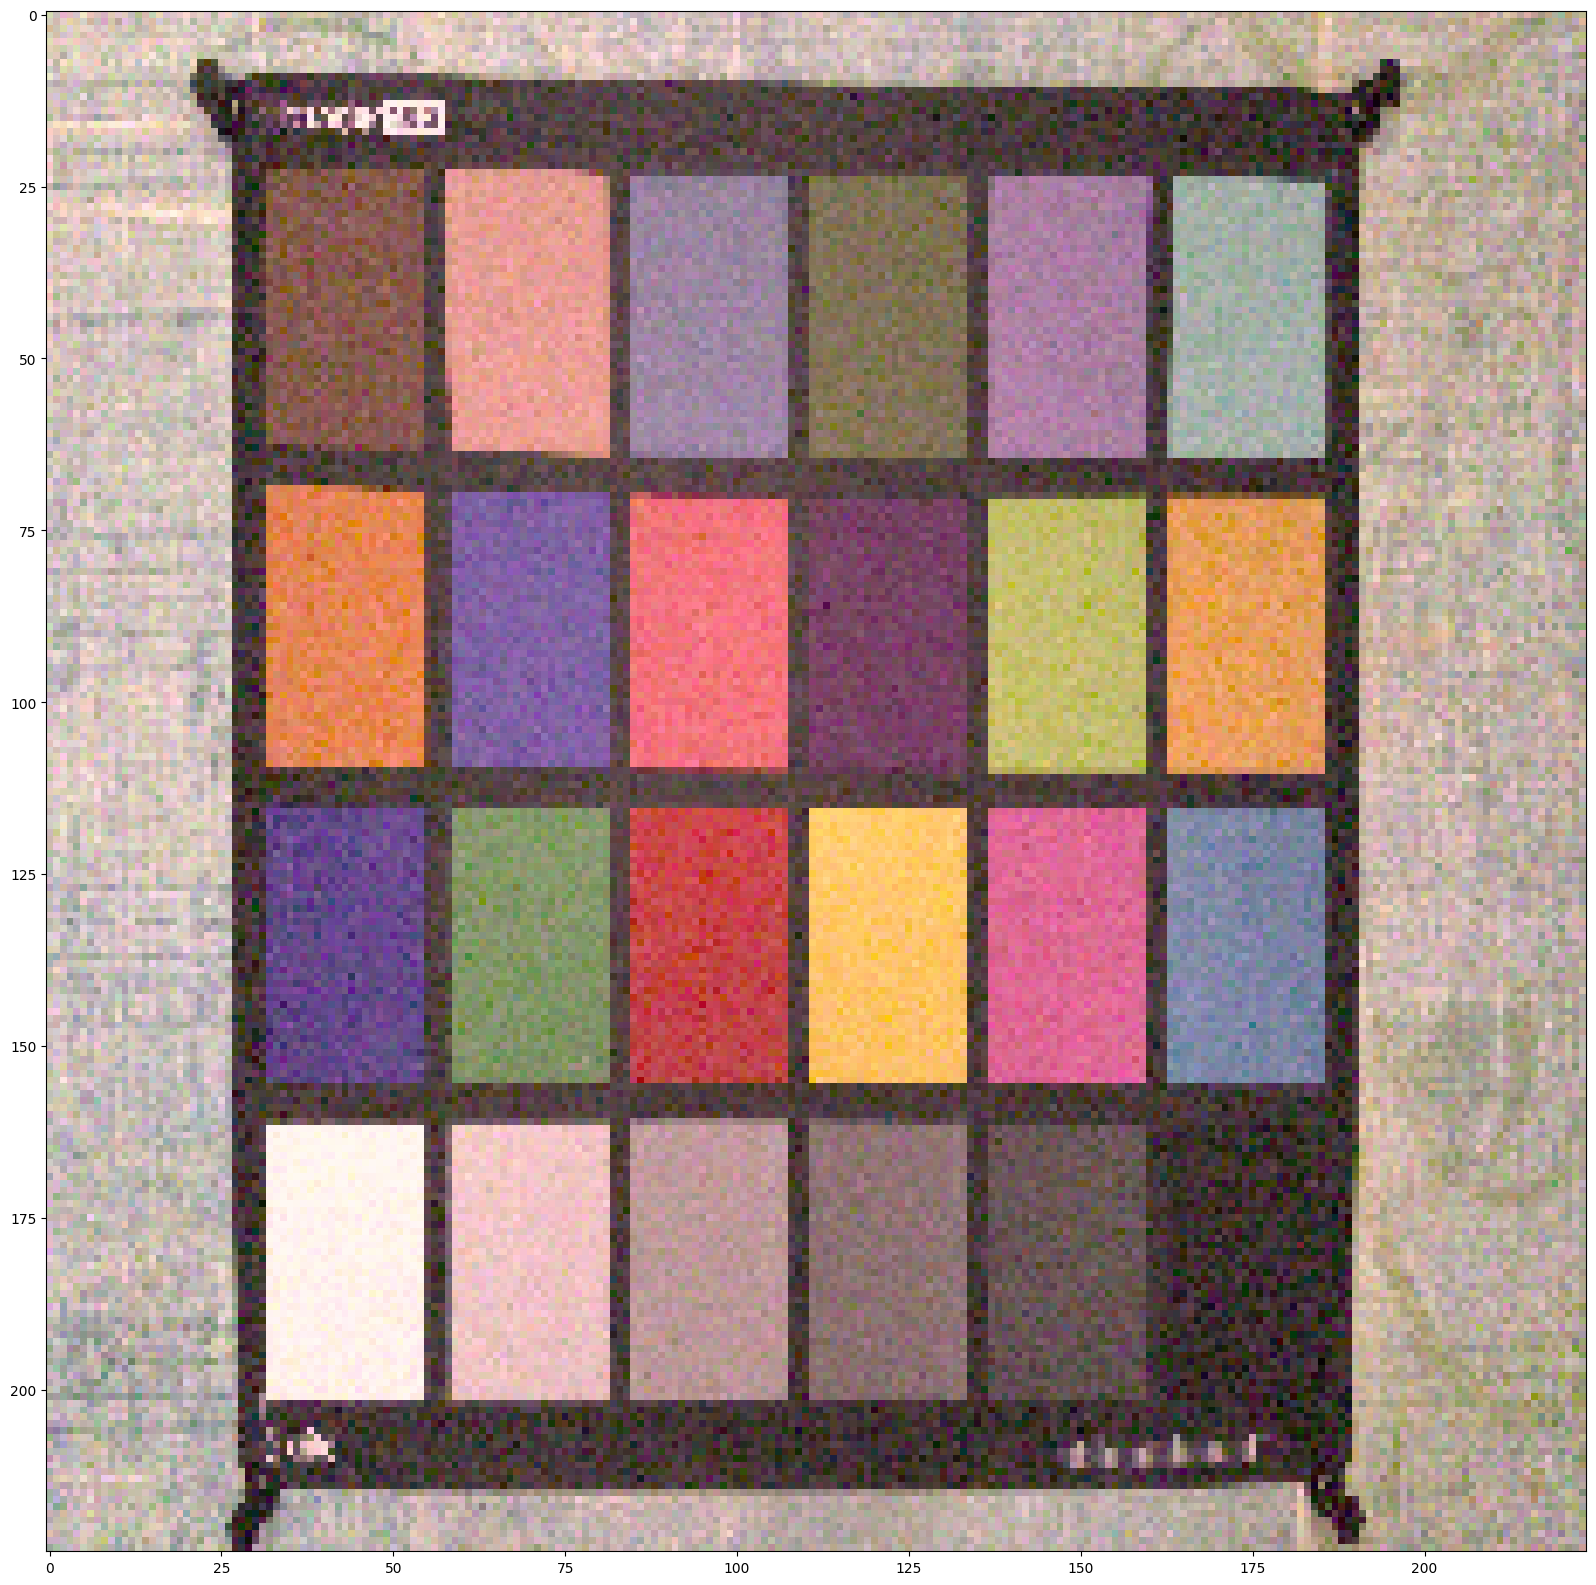

In [9]:
plt.figure(figsize=(20, 20))
plt.imshow(normal_sample)
plt.show()

plt.figure(figsize=(20, 20))
plt.imshow(noisy_sample)
plt.show()

In [10]:
kernel_sample = np.expand_dims(np.expand_dims(np.random.rand(FILTER_WIDTH, FILTER_HEIGHT), axis=-1), axis=0)
kernel_sample.shape, kernel_sample

((1, 9, 9, 1),
 array([[[[0.33793765],
          [0.52903604],
          [0.06274926],
          [0.406057  ],
          [0.99781772],
          [0.23253469],
          [0.96677286],
          [0.04486036],
          [0.58740335]],
 
         [[0.15771279],
          [0.47885285],
          [0.66436446],
          [0.1090321 ],
          [0.48252669],
          [0.90429176],
          [0.46523584],
          [0.45952131],
          [0.8165906 ]],
 
         [[0.72269505],
          [0.26302791],
          [0.47784502],
          [0.48467117],
          [0.06782911],
          [0.40492329],
          [0.52419508],
          [0.45139886],
          [0.13133565]],
 
         [[0.89113214],
          [0.64550961],
          [0.27226278],
          [0.57078561],
          [0.9868972 ],
          [0.67838122],
          [0.57146045],
          [0.03073035],
          [0.4474332 ]],
 
         [[0.56779283],
          [0.81219351],
          [0.70225513],
          [0.91715498],
          [0.

tf.Tensor(
[[[[0.038866   0.06606487 0.04200077]
   [0.04662396 0.04446739 0.06205793]
   [0.07330296 0.06884488 0.02905487]]]], shape=(1, 1, 3, 3), dtype=float32)
tf.Tensor(
[[[31 36 27]
  [30 34 25]
  [32 37 26]
  ...
  [22 27 21]
  [25 29 22]
  [26 30 23]]

 [[31 36 27]
  [29 34 25]
  [33 38 28]
  ...
  [24 28 21]
  [28 32 23]
  [28 33 25]]

 [[28 32 25]
  [30 34 25]
  [31 35 27]
  ...
  [25 28 20]
  [23 27 20]
  [26 30 22]]

 ...

 [[30 35 26]
  [28 32 24]
  [27 30 23]
  ...
  [25 29 22]
  [27 30 22]
  [24 28 20]]

 [[30 34 24]
  [30 34 24]
  [30 34 25]
  ...
  [28 33 24]
  [27 31 23]
  [28 32 23]]

 [[25 28 21]
  [27 30 23]
  [29 32 24]
  ...
  [21 25 19]
  [24 27 20]
  [26 31 22]]], shape=(224, 224, 3), dtype=int32)
tf.Tensor([[0.00568722]], shape=(1, 1), dtype=float32)


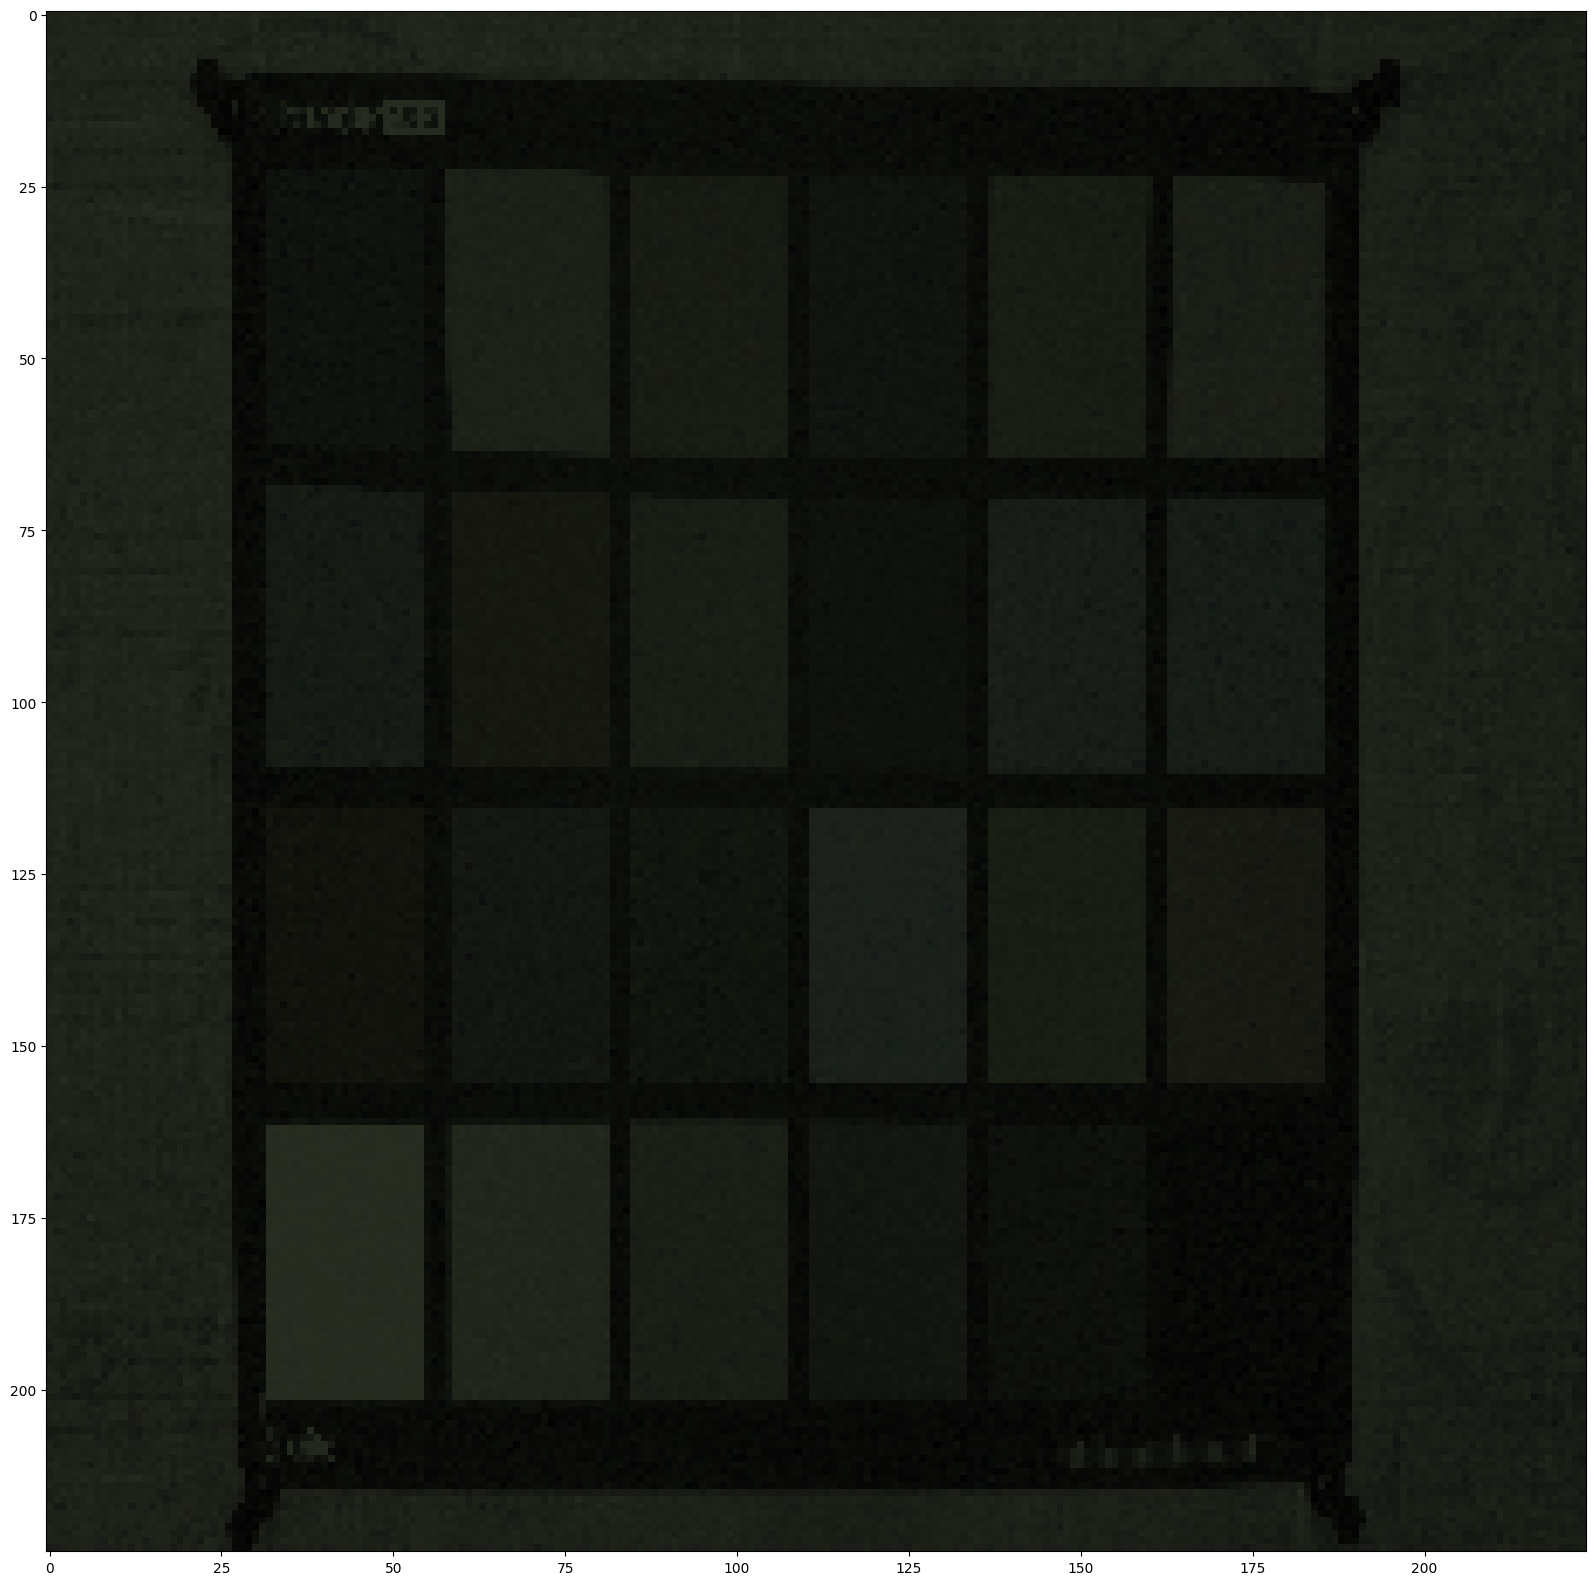

In [11]:
generated_kernel = generator(kernel_sample, training=False)
print(generated_kernel)
denoised_sample = tf.nn.conv2d(tf.cast(tf.expand_dims(noisy_sample, axis=0), dtype=tf.float32),
                               generated_kernel,
                               strides=[1, 1, 1, 1],
                               padding='SAME')
print(tf.cast(tf.squeeze(denoised_sample, axis=0), dtype=tf.int32))
decision = discriminator(denoised_sample, training=False)
print(decision)

plt.figure(figsize=(20, 20))
plt.imshow(tf.cast(tf.squeeze(denoised_sample, axis=0), dtype=tf.int32))
plt.show()

In [15]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9, 9, 1)]         0         
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          288       
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 16)          4608      
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 1)           144       
                                                                 
 tf.math.abs (TFOpLambda)    (None, 3, 3, 1)           0         
                                                                 
 tf.compat.v1.squeeze (TFOp  (None, 3, 3)              0         
 Lambda)                                                         
                                                         

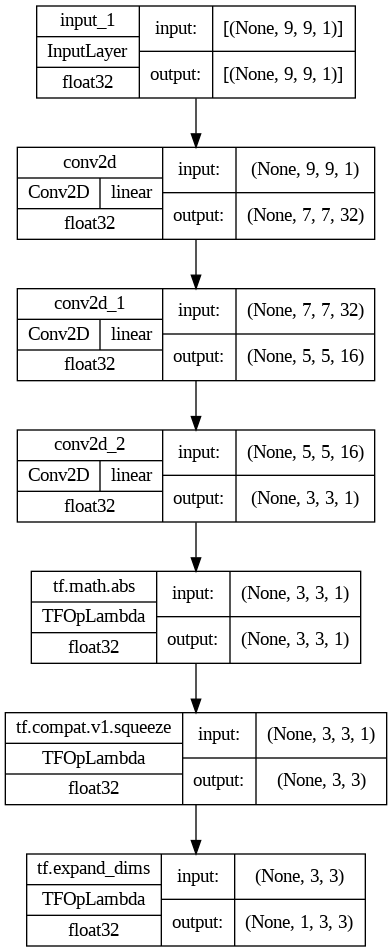

In [18]:
tf.keras.utils.plot_model(model=generator,
                          to_file='generator.png',
                          show_shapes=True,
                          show_dtype=True,
                          show_layer_names=True,
                          show_layer_activations=True)

In [19]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 500, 500, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 500, 500, 64)      1792      
                                                                 
 conv2d_4 (Conv2D)           (None, 500, 500, 128)     73856     
                                                                 
 global_average_pooling2d (  (None, 128)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                     

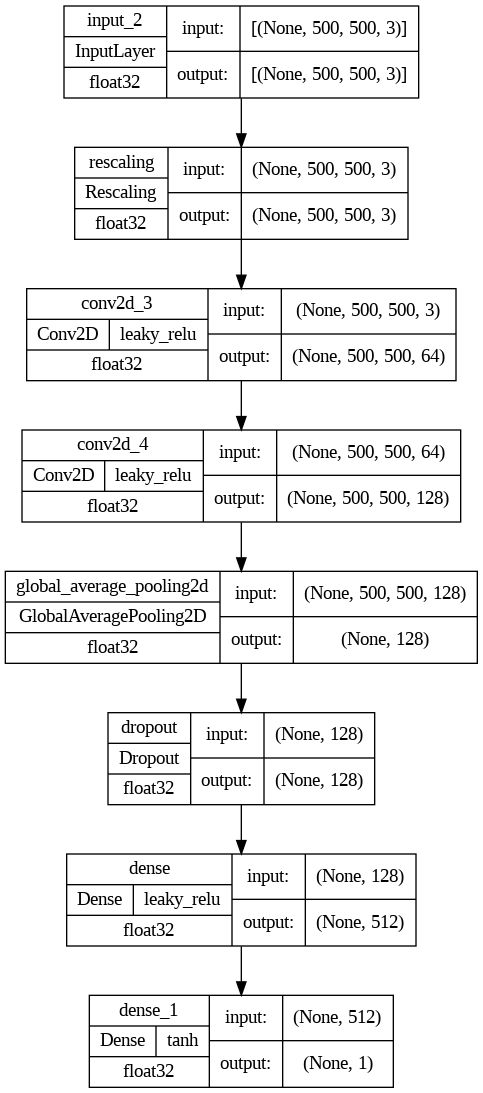

In [20]:
tf.keras.utils.plot_model(model=discriminator,
                          to_file='discriminator.png',
                          show_shapes=True,
                          show_dtype=True,
                          show_layer_names=True,
                          show_layer_activations=True)

## Define losses

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss

    return total_loss

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Define optimizers

In [15]:
# define the optimizers for both the generator and the discriminator
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

## Define training loop

In [16]:
def generate_predictions_and_save_images(model, epoch):
    # training is set to False so all layers run in inference mode
    kernel_prediction = model(kernel_sample, training=False)
    print(kernel_prediction)
    denoised_sample = tf.nn.conv2d(tf.cast(tf.expand_dims(noisy_sample, axis=0), dtype=tf.float32),
                                   kernel_prediction,
                                   strides=[1, 1, 1, 1],
                                   padding='SAME')
    print(tf.cast(tf.squeeze(denoised_sample, axis=0), dtype=tf.int32))

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(normal_sample)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(tf.cast(tf.squeeze(denoised_sample, axis=0), dtype=tf.int32))
    plt.axis('off')
    plt.savefig(f'image_at_epoch_{epoch:04d}.png')

In [17]:
# tf.function annotation causes the function to be "compiled"
@tf.function
def train_step(images):

    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        generated_kernel = generator(kernel_sample, training=True)
        # generated_kernel = tf.linalg.normalize(generated_kernel, ord='euclidean')[0]
        denoised_images = tf.nn.conv2d(tf.cast(tf.expand_dims(noisy_sample, axis=0), dtype=tf.float32),
                            generated_kernel,
                            strides=[1, 1, 1, 1],
                            padding='SAME')

        real_output = discriminator(images, training=True)
        fake_output = discriminator(denoised_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = generator_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = discriminator_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return (gen_loss, disc_loss)

In [18]:
def train(dataset, epochs):
    gen_disc_loss = []

    for epoch in range(epochs):
        print(f"Strating epoch {epoch+1}...")
        start = time.time()

        for image_batch in dataset:
            gen_disc_loss.append(train_step(image_batch))

        # produce images for the GIF
        generate_predictions_and_save_images(generator, epoch+1)

        print(f'Time for epoch {epoch+1} is {time.time()-start:.2f} seconds')

    # Generate after the final epoch
    generate_predictions_and_save_images(generator, epochs)
    return gen_disc_loss

Strating epoch 1...
tf.Tensor(
[[[[0.15130335 0.17107342 0.14497611]
   [0.16666761 0.1491058  0.15987507]
   [0.18422963 0.15834492 0.10772578]]]], shape=(1, 1, 3, 3), dtype=float32)
tf.Tensor(
[[[102  97  85]
  [ 97  92  80]
  [103  99  84]
  ...
  [ 75  73  64]
  [ 83  80  69]
  [ 86  83  72]]

 [[101  97  84]
  [ 95  91  78]
  [106 102  88]
  ...
  [ 79  76  66]
  [ 90  86  74]
  [ 92  90  78]]

 [[ 91  88  77]
  [ 96  92  79]
  [100  96  84]
  ...
  [ 79  76  65]
  [ 75  73  63]
  [ 84  81  70]]

 ...

 [[ 98  94  82]
  [ 91  87  75]
  [ 86  82  71]
  ...
  [ 83  80  70]
  [ 85  81  70]
  [ 78  75  64]]

 [[ 95  91  77]
  [ 95  91  78]
  [ 96  92  78]
  ...
  [ 91  87  75]
  [ 87  83  72]
  [ 89  85  72]]

 [[ 79  75  65]
  [ 87  83  72]
  [ 92  87  75]
  ...
  [ 70  67  58]
  [ 76  73  63]
  [ 85  82  71]]], shape=(224, 224, 3), dtype=int32)
Time for epoch 1 is 69.43 seconds
Strating epoch 2...


tf.Tensor(
[[[[0.32343832 0.33679152 0.30699822]
   [0.3488512  0.31432068 0.31522733]
   [0.35556772 0.3040607  0.24073808]]]], shape=(1, 1, 3, 3), dtype=float32)
tf.Tensor(
[[[209 195 178]
  [198 185 167]
  [211 198 178]
  ...
  [155 147 134]
  [171 160 145]
  [177 166 151]]

 [[207 193 175]
  [195 182 165]
  [219 204 184]
  ...
  [163 152 138]
  [185 172 155]
  [191 179 163]]

 [[188 177 161]
  [197 184 166]
  [207 193 176]
  ...
  [162 151 136]
  [155 146 132]
  [173 162 147]]

 ...

 [[201 189 171]
  [187 175 158]
  [176 164 148]
  ...
  [171 160 146]
  [175 162 147]
  [161 150 135]]

 [[195 181 163]
  [195 182 163]
  [197 183 165]
  ...
  [187 174 157]
  [178 166 151]
  [182 169 152]]

 [[162 151 136]
  [179 166 151]
  [188 175 158]
  ...
  [144 134 122]
  [157 146 132]
  [175 164 149]]], shape=(224, 224, 3), dtype=int32)
Time for epoch 2 is 67.13 seconds
Strating epoch 3...


tf.Tensor(
[[[[0.4946681  0.48905474 0.45954776]
   [0.5268825  0.46592152 0.45903233]
   [0.52106535 0.43682733 0.36367744]]]], shape=(1, 1, 3, 3), dtype=float32)
tf.Tensor(
[[[315 285 264]
  [298 269 248]
  [317 288 264]
  ...
  [234 214 199]
  [257 233 216]
  [267 242 225]]

 [[312 282 261]
  [293 265 245]
  [329 298 274]
  ...
  [245 222 206]
  [278 251 231]
  [287 262 243]]

 [[283 258 239]
  [296 268 247]
  [311 282 261]
  ...
  [244 221 203]
  [234 212 196]
  [260 236 218]]

 ...

 [[303 276 255]
  [281 255 235]
  [264 239 220]
  ...
  [257 233 216]
  [263 237 218]
  [242 219 202]]

 [[292 264 243]
  [293 265 243]
  [296 267 245]
  ...
  [281 254 234]
  [268 242 224]
  [273 247 227]]

 [[244 220 203]
  [269 242 224]
  [282 255 235]
  ...
  [216 196 181]
  [236 213 197]
  [263 240 221]]], shape=(224, 224, 3), dtype=int32)
Time for epoch 3 is 51.06 seconds
tf.Tensor(
[[[[0.4946681  0.48905474 0.45954776]
   [0.5268825  0.46592152 0.45903233]
   [0.52106535 0.43682733 0.36367744]]]

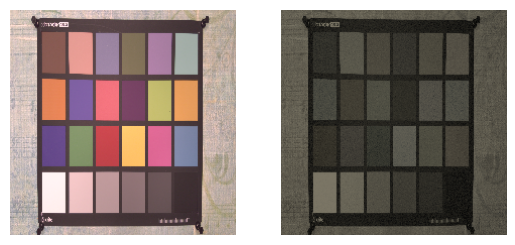

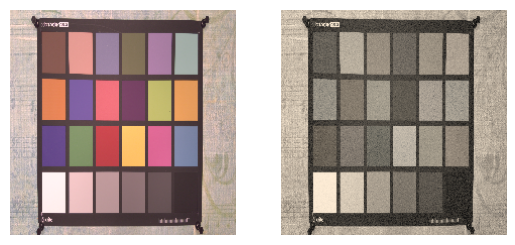

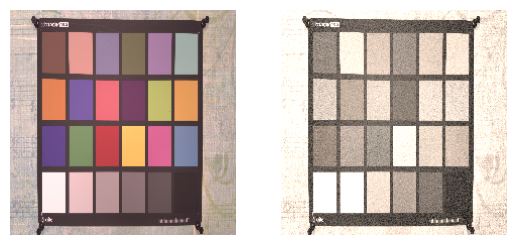

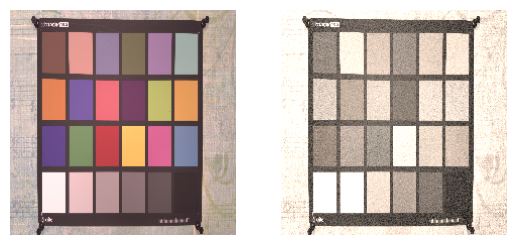

In [19]:
losses = train(train_dataset, EPOCHS)

In [121]:
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}")
    print(f"Generator loss: {losses[epoch][0].numpy():.4f}")
    print(f"Discriminator loss: {losses[epoch][1].numpy():.4f}\n")

Epoch 1
Generator loss: 0.6921
Discriminator loss: 1.3661

Epoch 2
Generator loss: 0.6873
Discriminator loss: 1.3637

Epoch 3
Generator loss: 0.6852
Discriminator loss: 1.3647



tf.Tensor(
[[[[0.4946681  0.48905474 0.45954776]
   [0.5268825  0.46592152 0.45903233]
   [0.52106535 0.43682733 0.36367744]]]], shape=(1, 1, 3, 3), dtype=float32)
tf.Tensor(
[[[315 285 264]
  [298 269 248]
  [317 288 264]
  ...
  [234 214 199]
  [257 233 216]
  [267 242 225]]

 [[312 282 261]
  [293 265 245]
  [329 298 274]
  ...
  [245 222 206]
  [278 251 231]
  [287 262 243]]

 [[283 258 239]
  [296 268 247]
  [311 282 261]
  ...
  [244 221 203]
  [234 212 196]
  [260 236 218]]

 ...

 [[303 276 255]
  [281 255 235]
  [264 239 220]
  ...
  [257 233 216]
  [263 237 218]
  [242 219 202]]

 [[292 264 243]
  [293 265 243]
  [296 267 245]
  ...
  [281 254 234]
  [268 242 224]
  [273 247 227]]

 [[244 220 203]
  [269 242 224]
  [282 255 235]
  ...
  [216 196 181]
  [236 213 197]
  [263 240 221]]], shape=(224, 224, 3), dtype=int32)
tf.Tensor([[-0.19144179]], shape=(1, 1), dtype=float32)


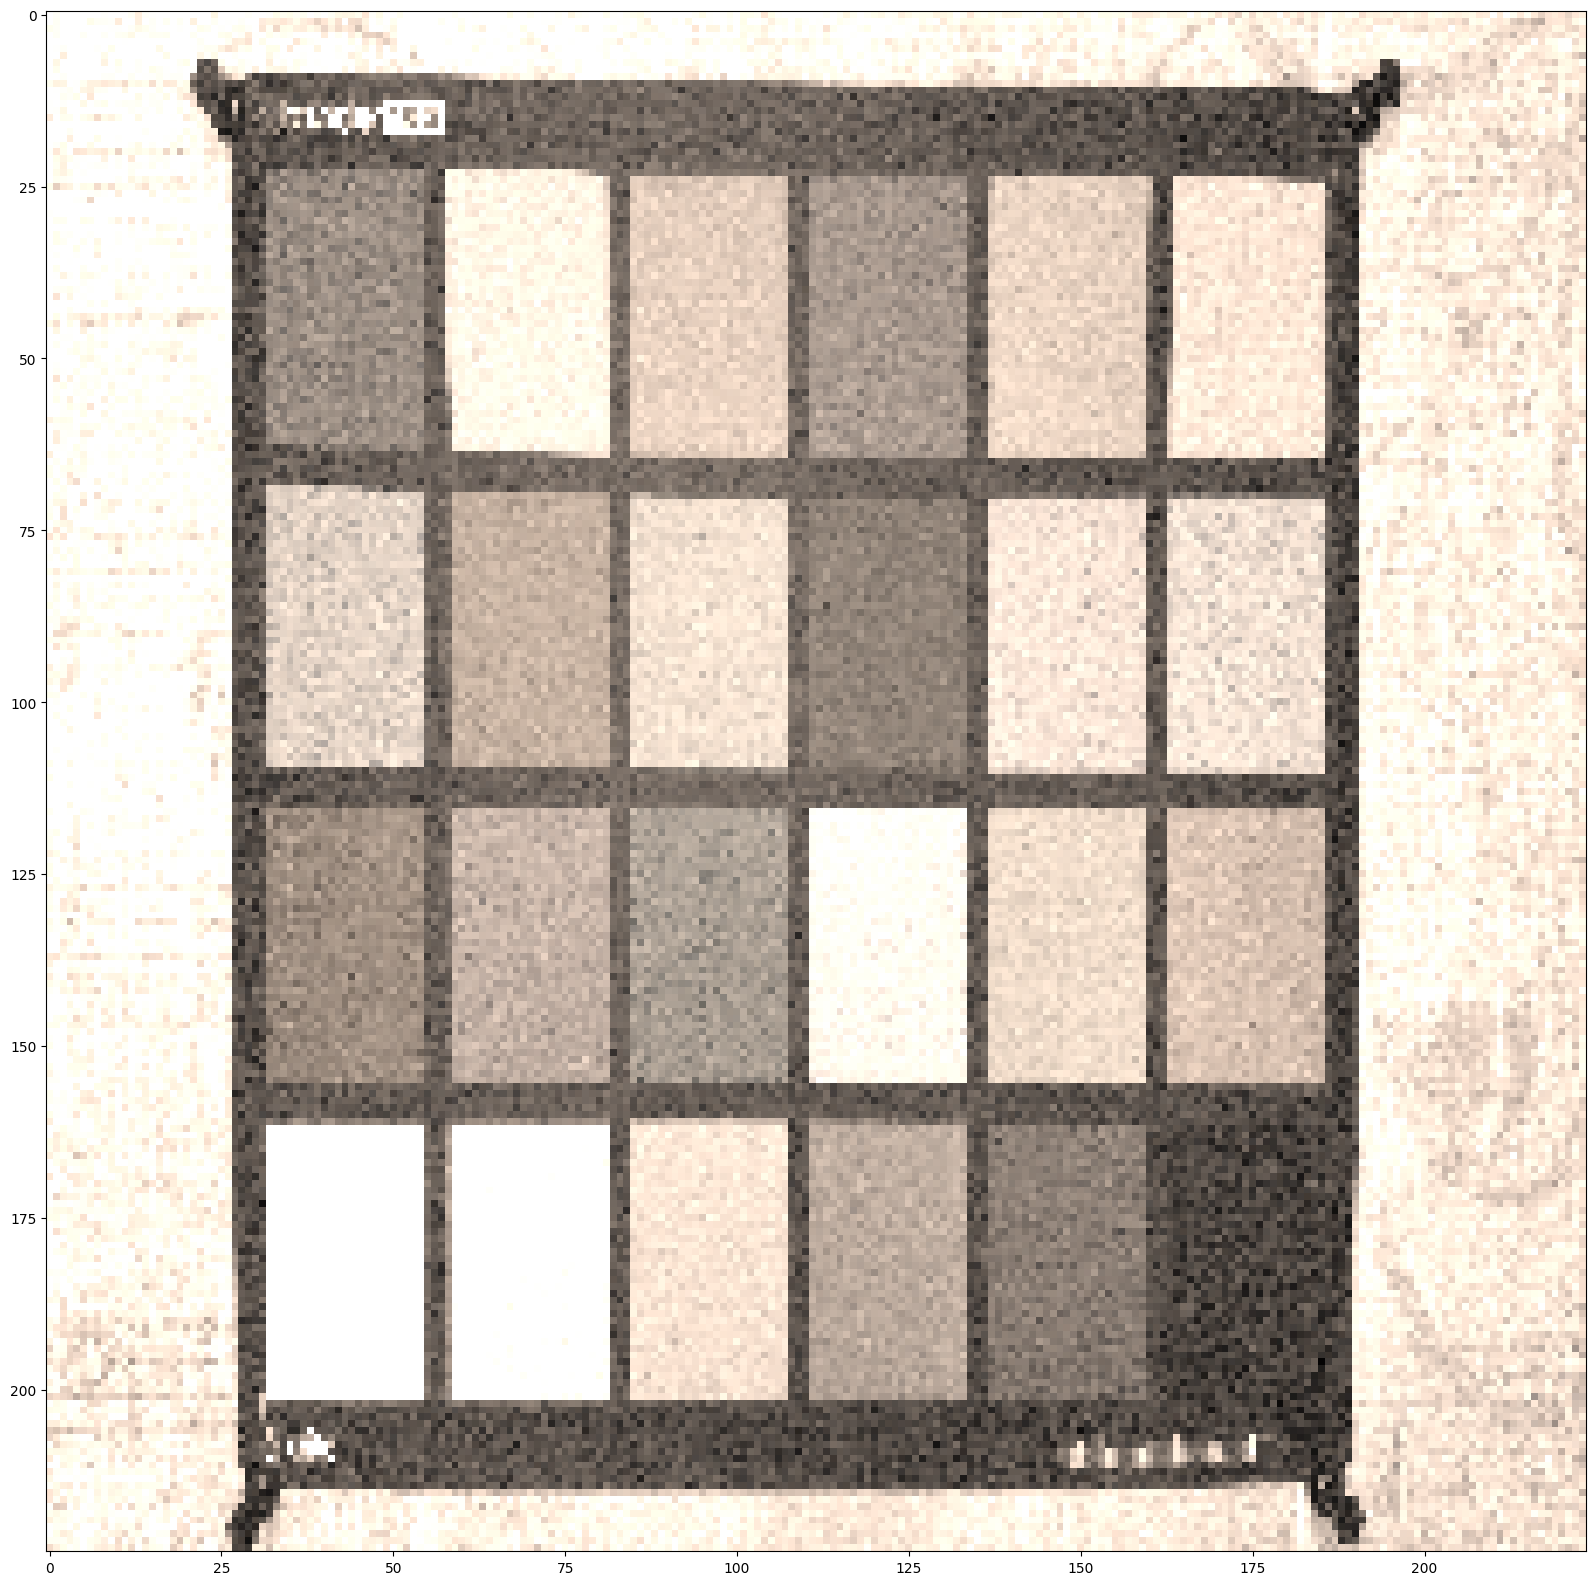

In [20]:
generated_kernel = generator(kernel_sample, training=False)
print(generated_kernel)
denoised_sample = tf.nn.conv2d(tf.cast(tf.expand_dims(noisy_sample, axis=0), dtype=tf.float32),
                               generated_kernel,
                               strides=[1, 1, 1, 1],
                               padding='SAME')
print(tf.cast(tf.squeeze(denoised_sample, axis=0), dtype=tf.int32))
decision = discriminator(denoised_sample, training=False)
print(decision)

plt.figure(figsize=(20, 20))
plt.imshow(tf.cast(tf.squeeze(denoised_sample, axis=0), dtype=tf.int32))
plt.show()

In [21]:
# check normalized generated kernel
print(f"Initial kernel:\n {generated_kernel}")
print(f"\nKernel after normalization:\n {tf.linalg.normalize(generated_kernel, ord='euclidean')[0]}")

Initial kernel:
 [[[[0.4946681  0.48905474 0.45954776]
   [0.5268825  0.46592152 0.45903233]
   [0.52106535 0.43682733 0.36367744]]]]

Kernel after normalization:
 [[[[0.3502175  0.34624332 0.32535282]
   [0.37302482 0.32986534 0.32498792]
   [0.36890635 0.3092671  0.2574781 ]]]]


tf.Tensor(
[[[[0.4946681  0.48905474 0.45954776]
   [0.5268825  0.46592152 0.45903233]
   [0.52106535 0.43682733 0.36367744]]]], shape=(1, 1, 3, 3), dtype=float32)
tf.Tensor(
[[[223 202 187]
  [211 191 176]
  [225 204 187]
  ...
  [166 151 141]
  [182 165 153]
  [189 171 159]]

 [[221 200 184]
  [207 188 173]
  [233 211 194]
  ...
  [173 157 146]
  [197 178 163]
  [203 185 172]]

 [[200 182 169]
  [209 189 175]
  [220 199 185]
  ...
  [173 156 144]
  [165 150 139]
  [184 167 154]]

 ...

 [[214 195 180]
  [199 180 166]
  [187 169 156]
  ...
  [182 165 153]
  [186 167 154]
  [171 155 143]]

 [[207 187 172]
  [207 187 172]
  [209 189 174]
  ...
  [199 180 165]
  [189 171 158]
  [193 175 160]]

 [[173 155 143]
  [190 171 159]
  [200 180 166]
  ...
  [153 139 128]
  [167 151 139]
  [186 170 157]]], shape=(224, 224, 3), dtype=int32)
tf.Tensor([[-0.14963734]], shape=(1, 1), dtype=float32)


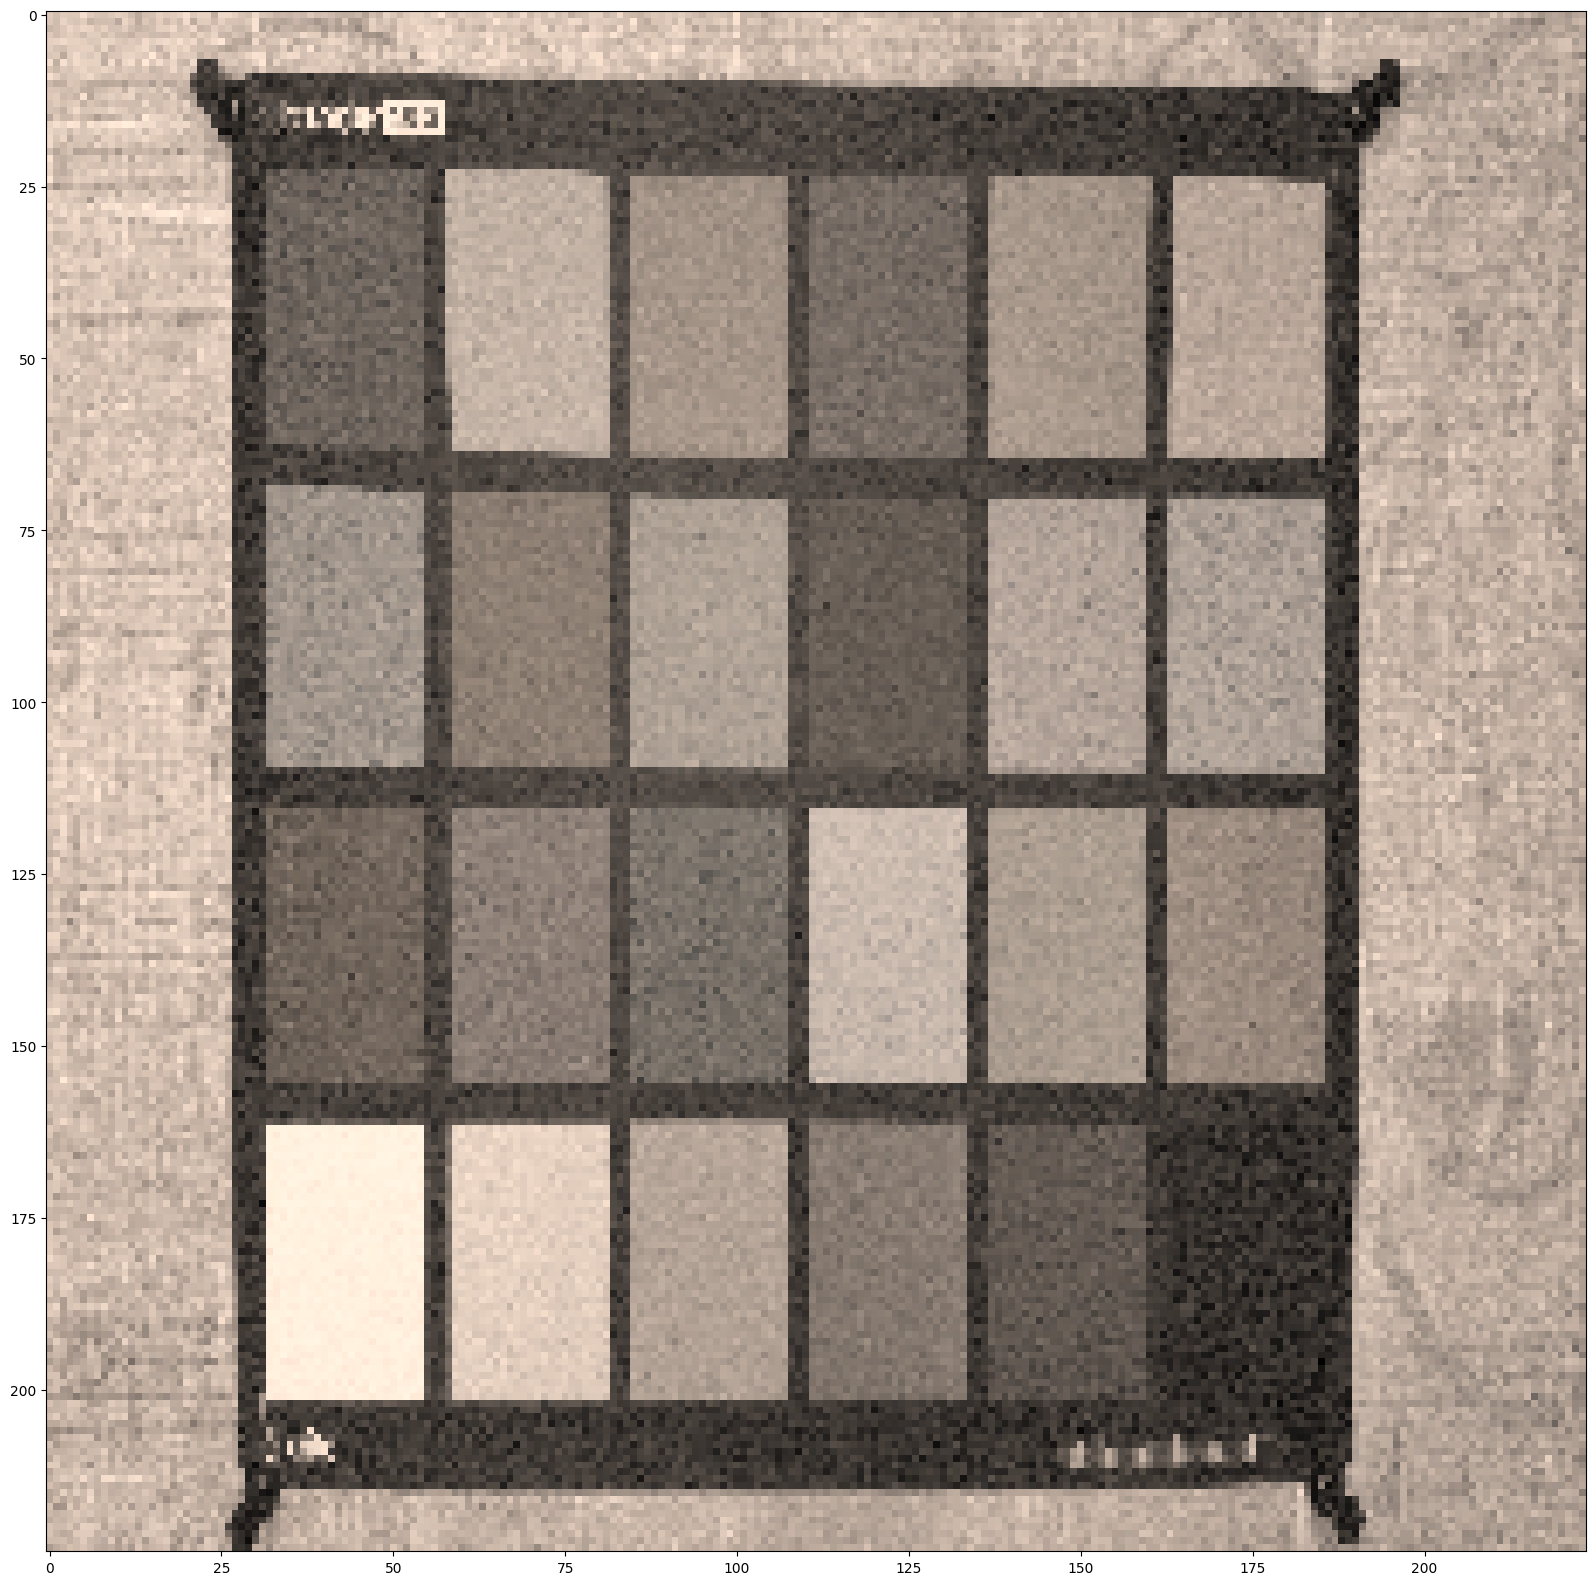

In [22]:
# use normalized kernel for denoising
generated_kernel = generator(kernel_sample, training=False)
print(generated_kernel)
denoised_sample = tf.nn.conv2d(tf.cast(tf.expand_dims(noisy_sample, axis=0), dtype=tf.float32),
                               tf.linalg.normalize(generated_kernel, ord='euclidean')[0],
                               strides=[1, 1, 1, 1],
                               padding='SAME')
print(tf.cast(tf.squeeze(denoised_sample, axis=0), dtype=tf.int32))
decision = discriminator(denoised_sample, training=False)
print(decision)

plt.figure(figsize=(20, 20))
plt.imshow(tf.cast(tf.squeeze(denoised_sample, axis=0), dtype=tf.int32))
plt.show()

In [65]:
flatten_denoised = tf.reshape(tf.cast(tf.squeeze(denoised_sample, axis=0), dtype=tf.int32), shape=[-1])
flatten_normal = tf.reshape(normal_sample, shape=[-1])

print(f"Pixel-wise accuracy: {accuracy_score(flatten_normal, flatten_denoised):.4f}")

cos_sim = cosine_similarity(np.expand_dims(flatten_normal, axis=0), np.expand_dims(flatten_denoised, axis=0))[0][0]
print(f"Pixel-wise cosine similarity: {cos_sim:.4f}")

ssim = structural_similarity(normal_sample, tf.cast(tf.squeeze(denoised_sample, axis=0), dtype=tf.int32).numpy(),
                             channel_axis=2)
print(f'Structural Similarity Index (SSIM): {ssim:.4f}')

Pixel-wise accuracy: 0.0274
Pixel-wise cosine similarity: 0.9888
Structural Similarity Index (SSIM): 1.0000


# Baseline filters (different filters used for denoising images)

In [109]:
# define kernel size for the filters
kernel_size = 3

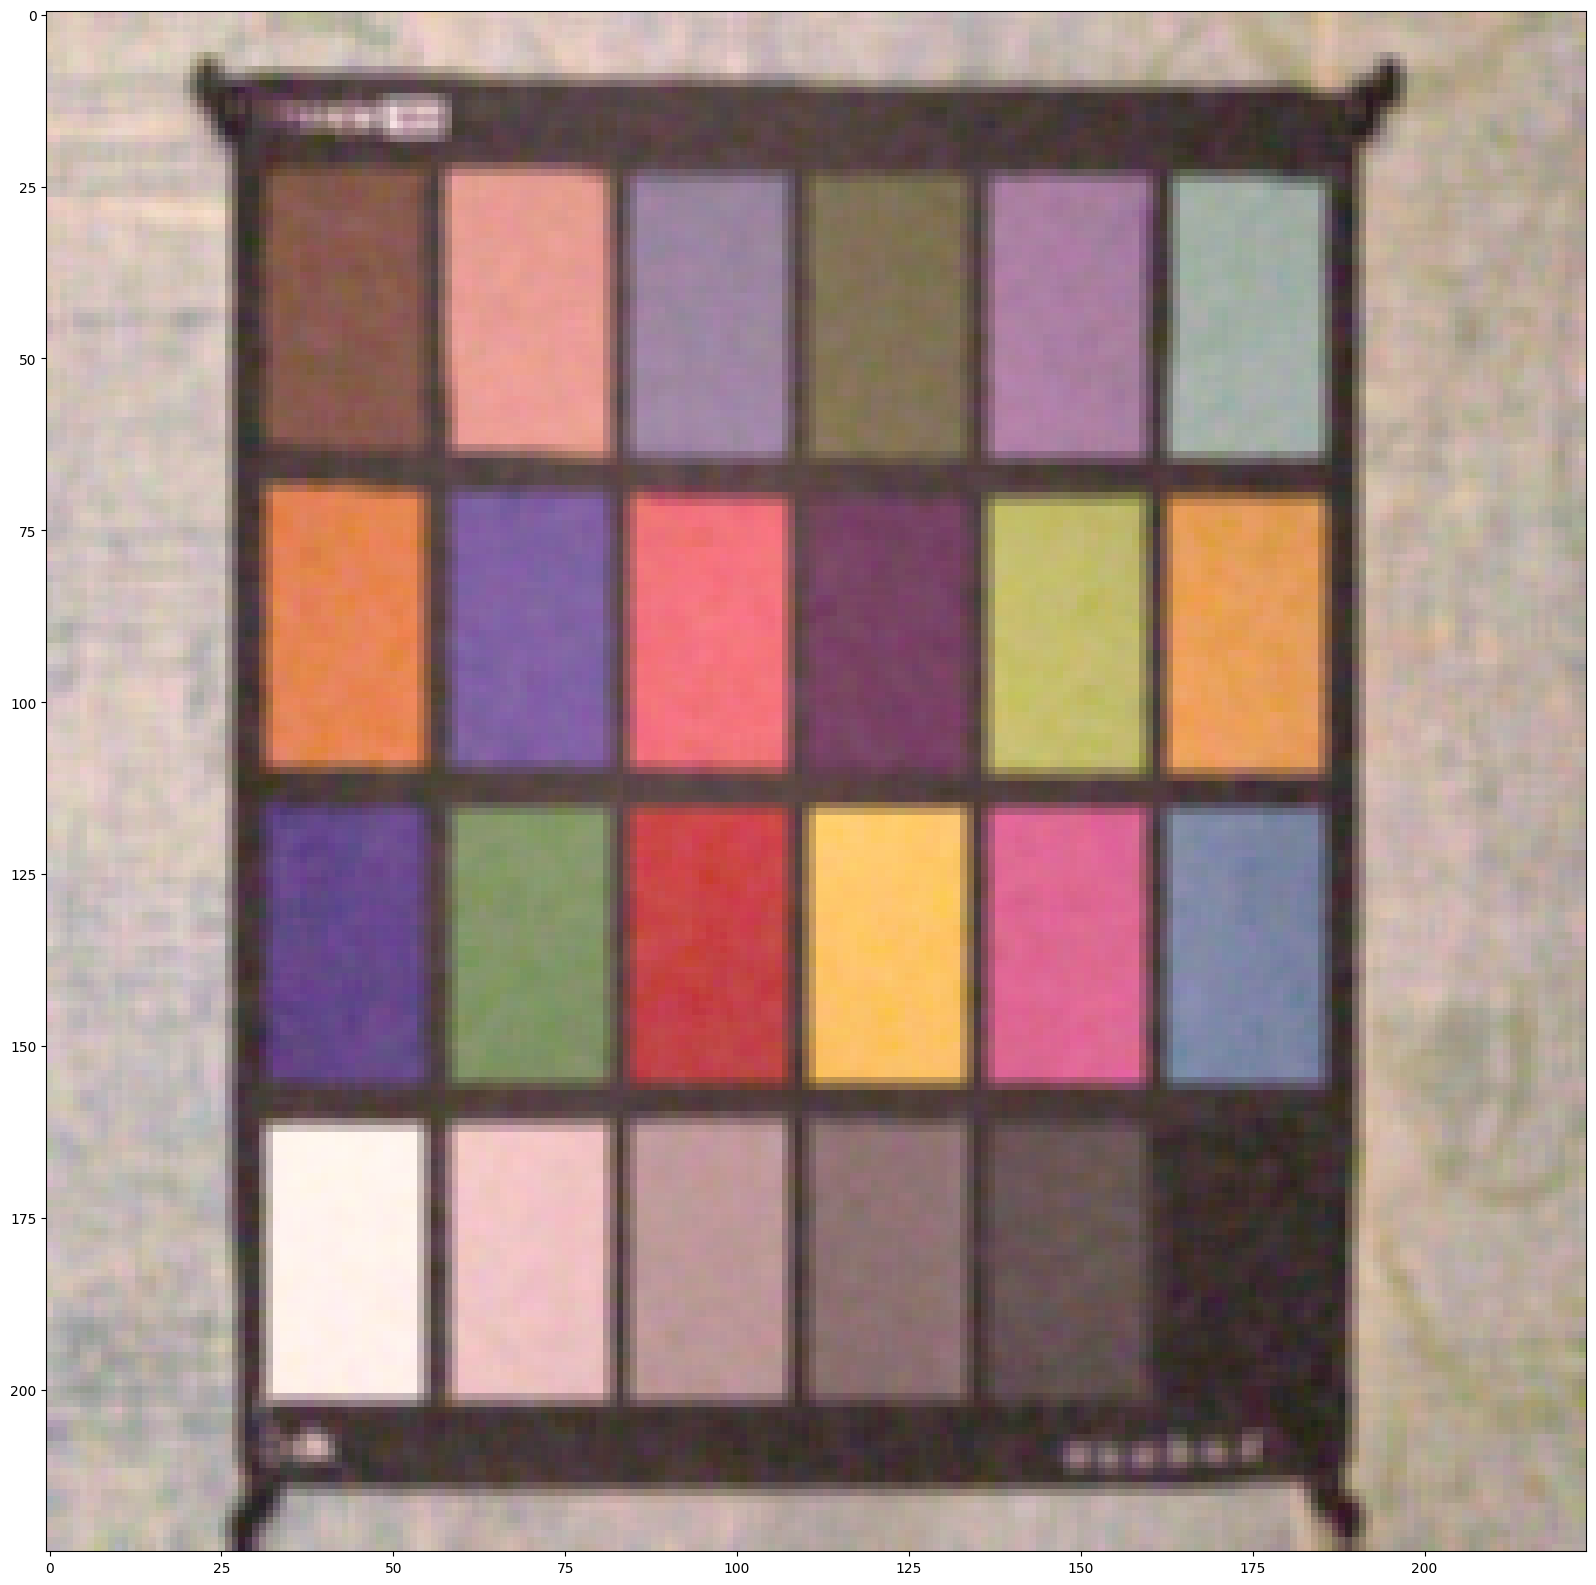

In [111]:
# apply mean filter
mean_filtered = cv2.blur(noisy_sample, (kernel_size, kernel_size))

plt.figure(figsize=(20, 20))
plt.imshow(mean_filtered)
plt.show()

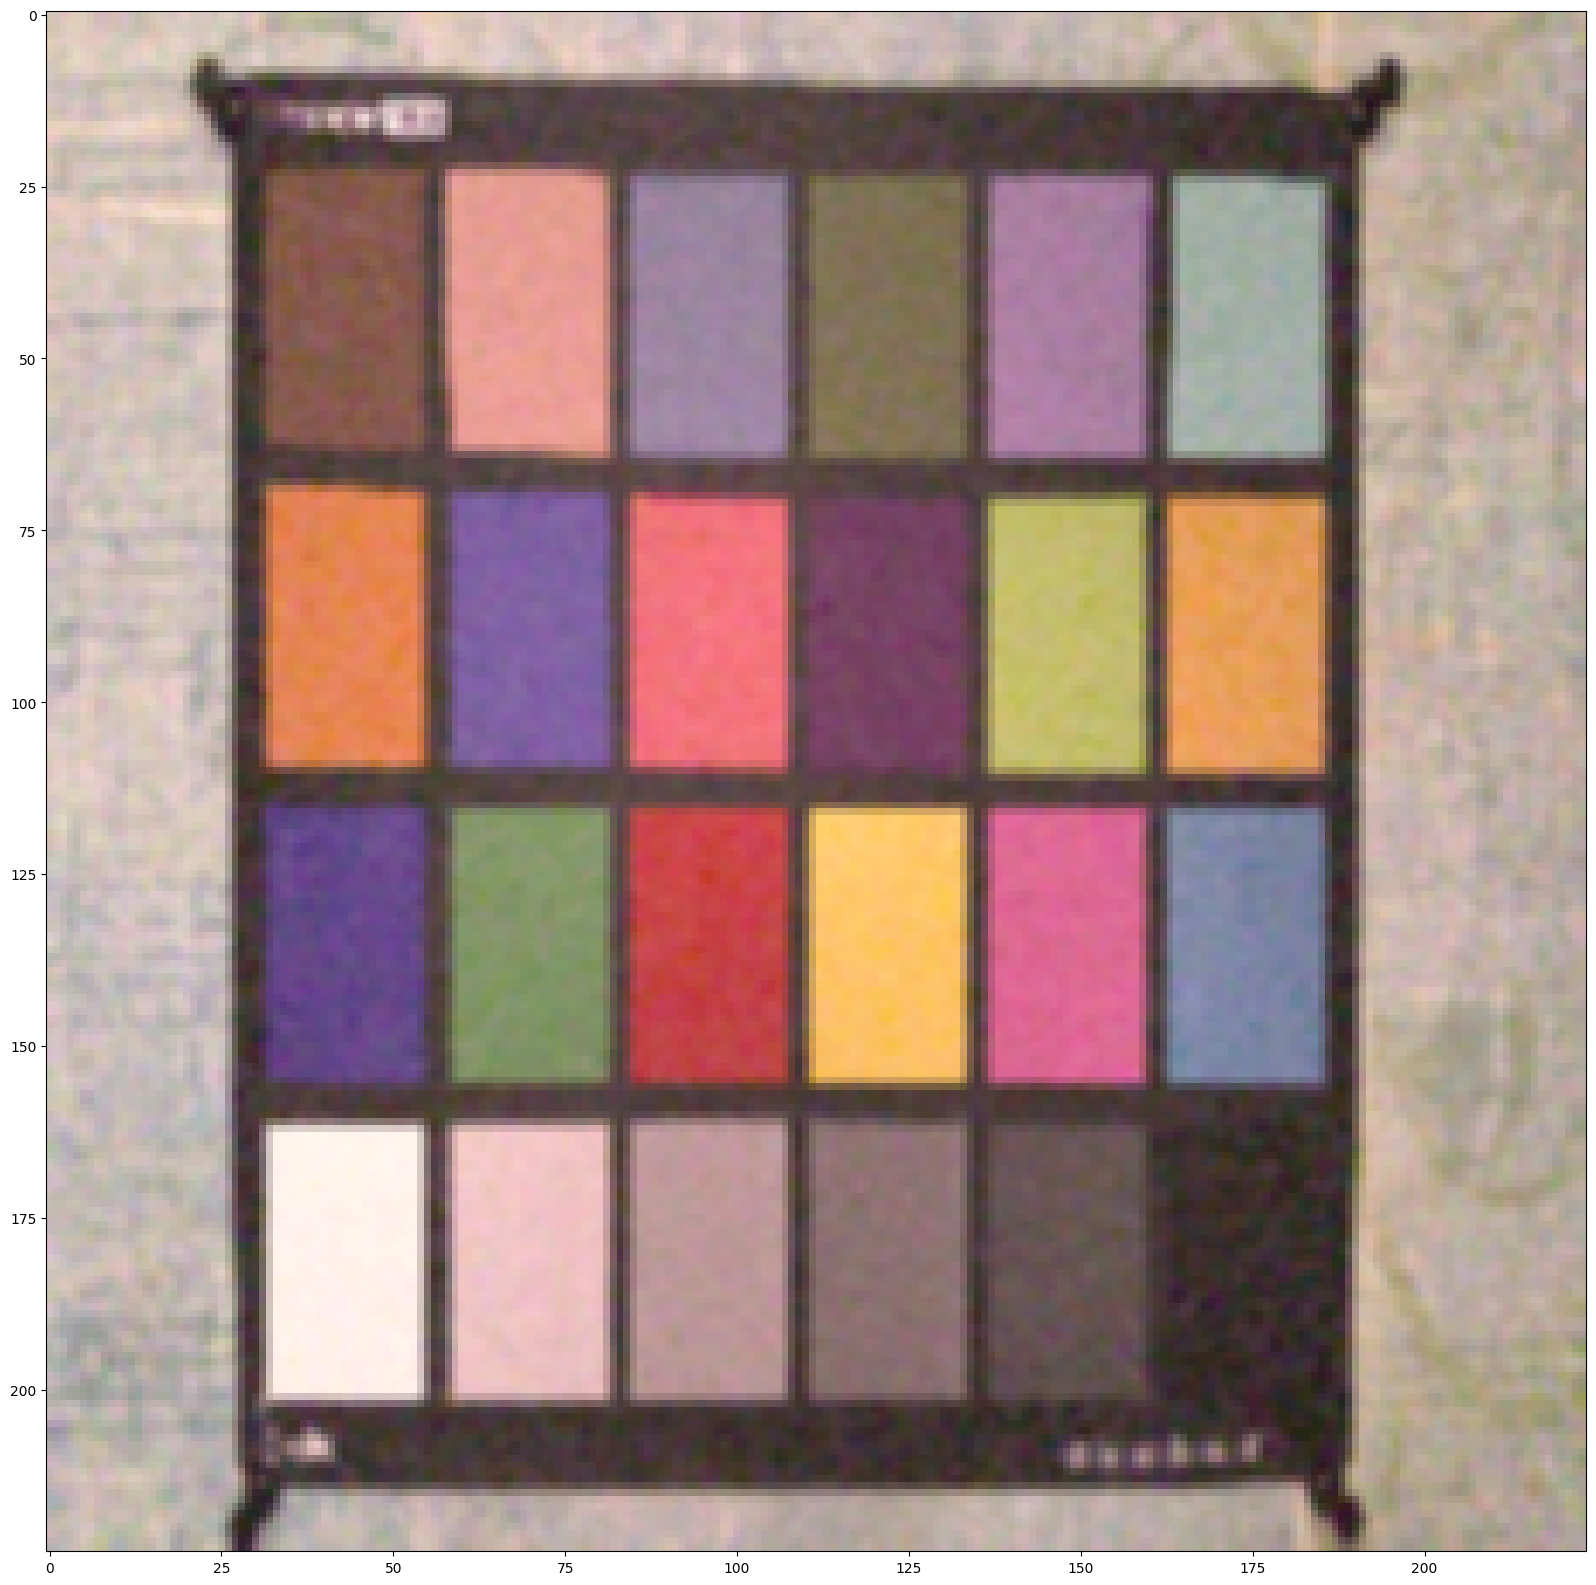

In [112]:
# apply Gaussian filter with the parameter standard deviation
gaussian_filtered = cv2.GaussianBlur(np.array(noisy_sample, dtype=np.float32), (kernel_size, kernel_size), sigmaX=0, sigmaY=0)

plt.figure(figsize=(20, 20))
plt.imshow(np.array(gaussian_filtered, dtype=np.int32))
plt.show()

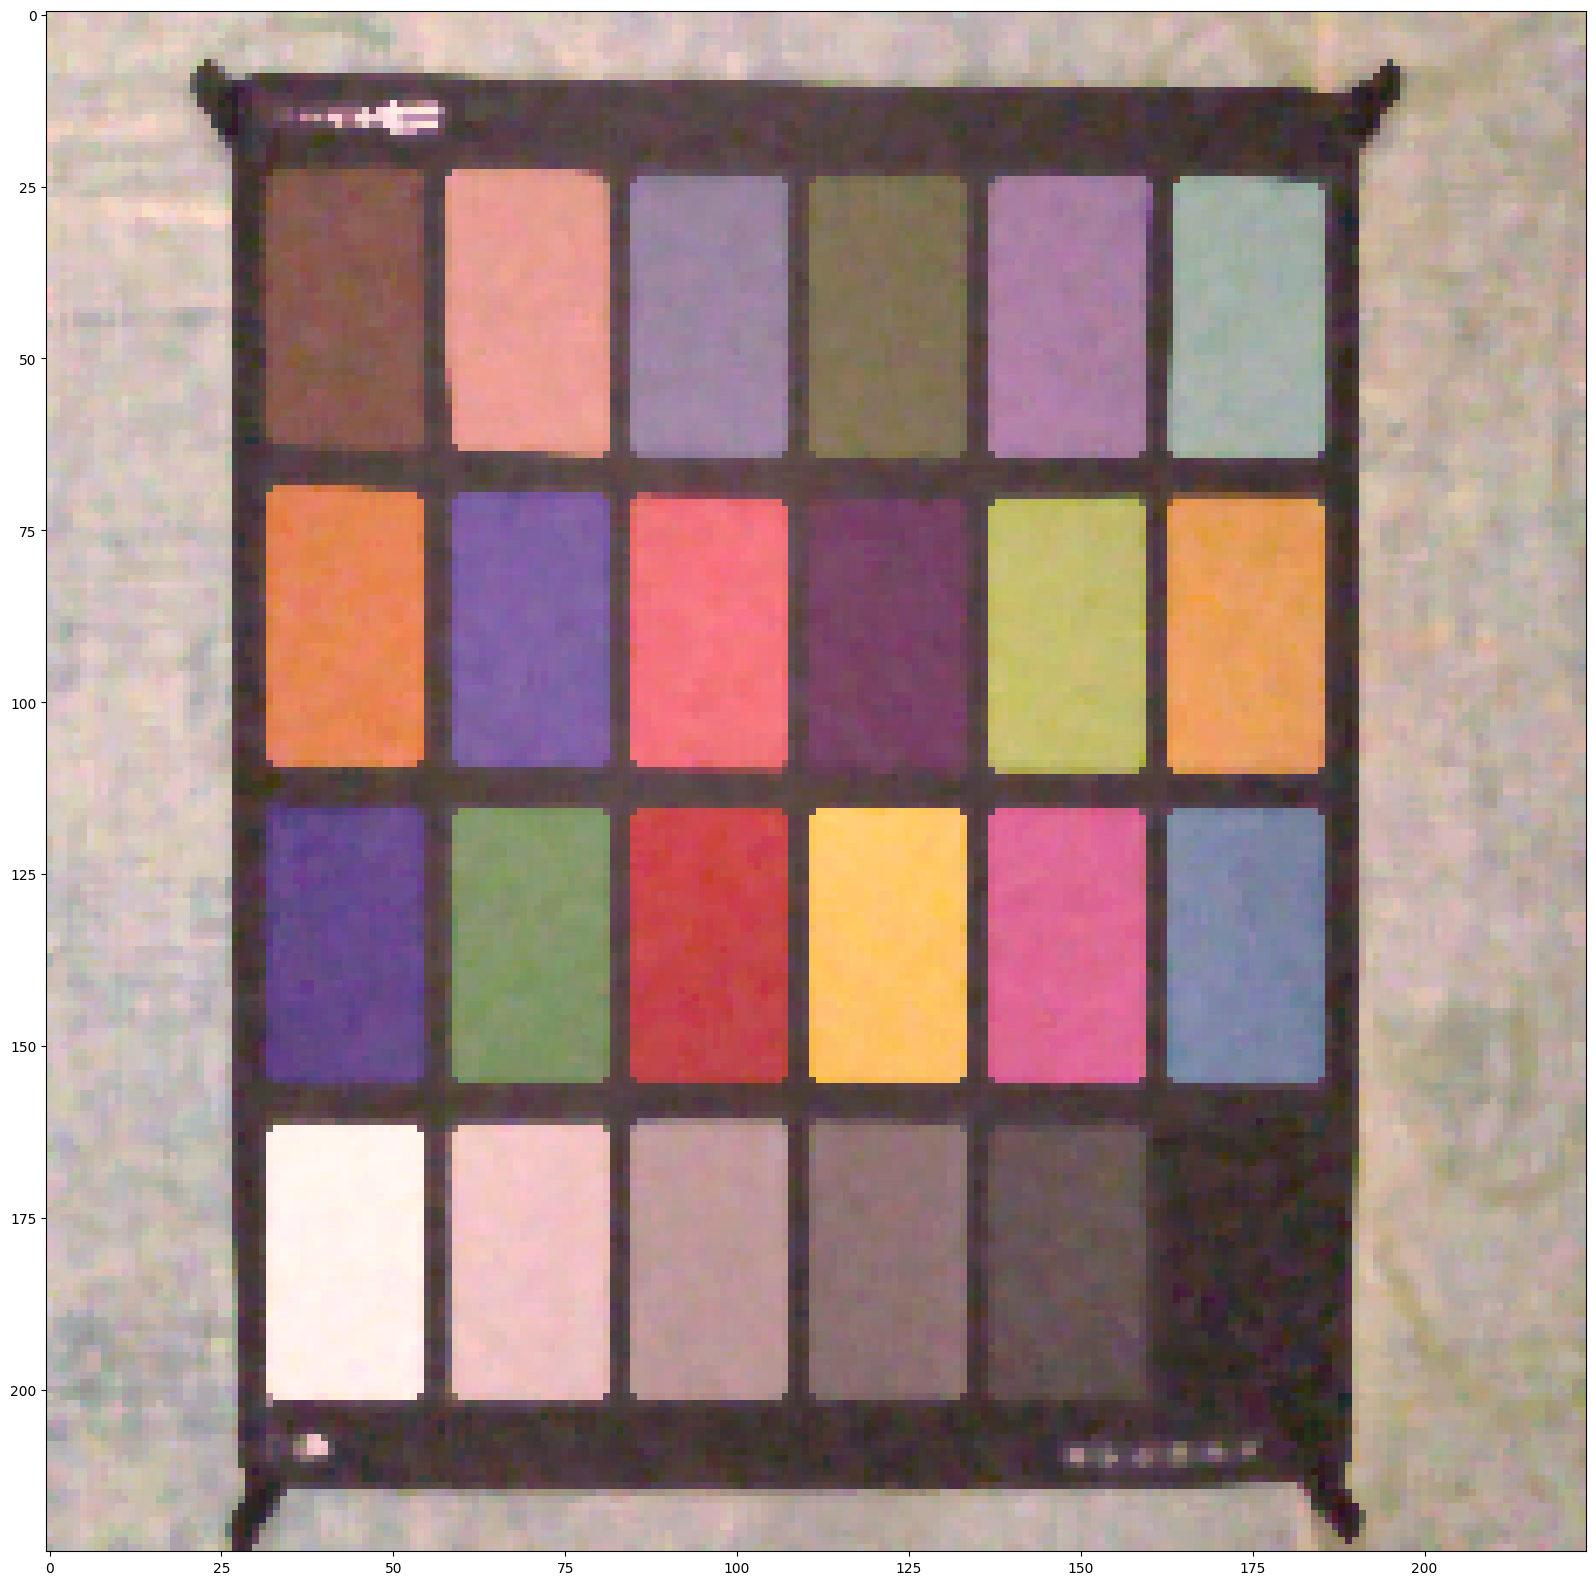

In [113]:
# apply median filter
median_filtered = cv2.medianBlur(np.array(noisy_sample, dtype=np.float32), kernel_size)

plt.figure(figsize=(20, 20))
plt.imshow(np.array(median_filtered, dtype=np.int32))
plt.show()

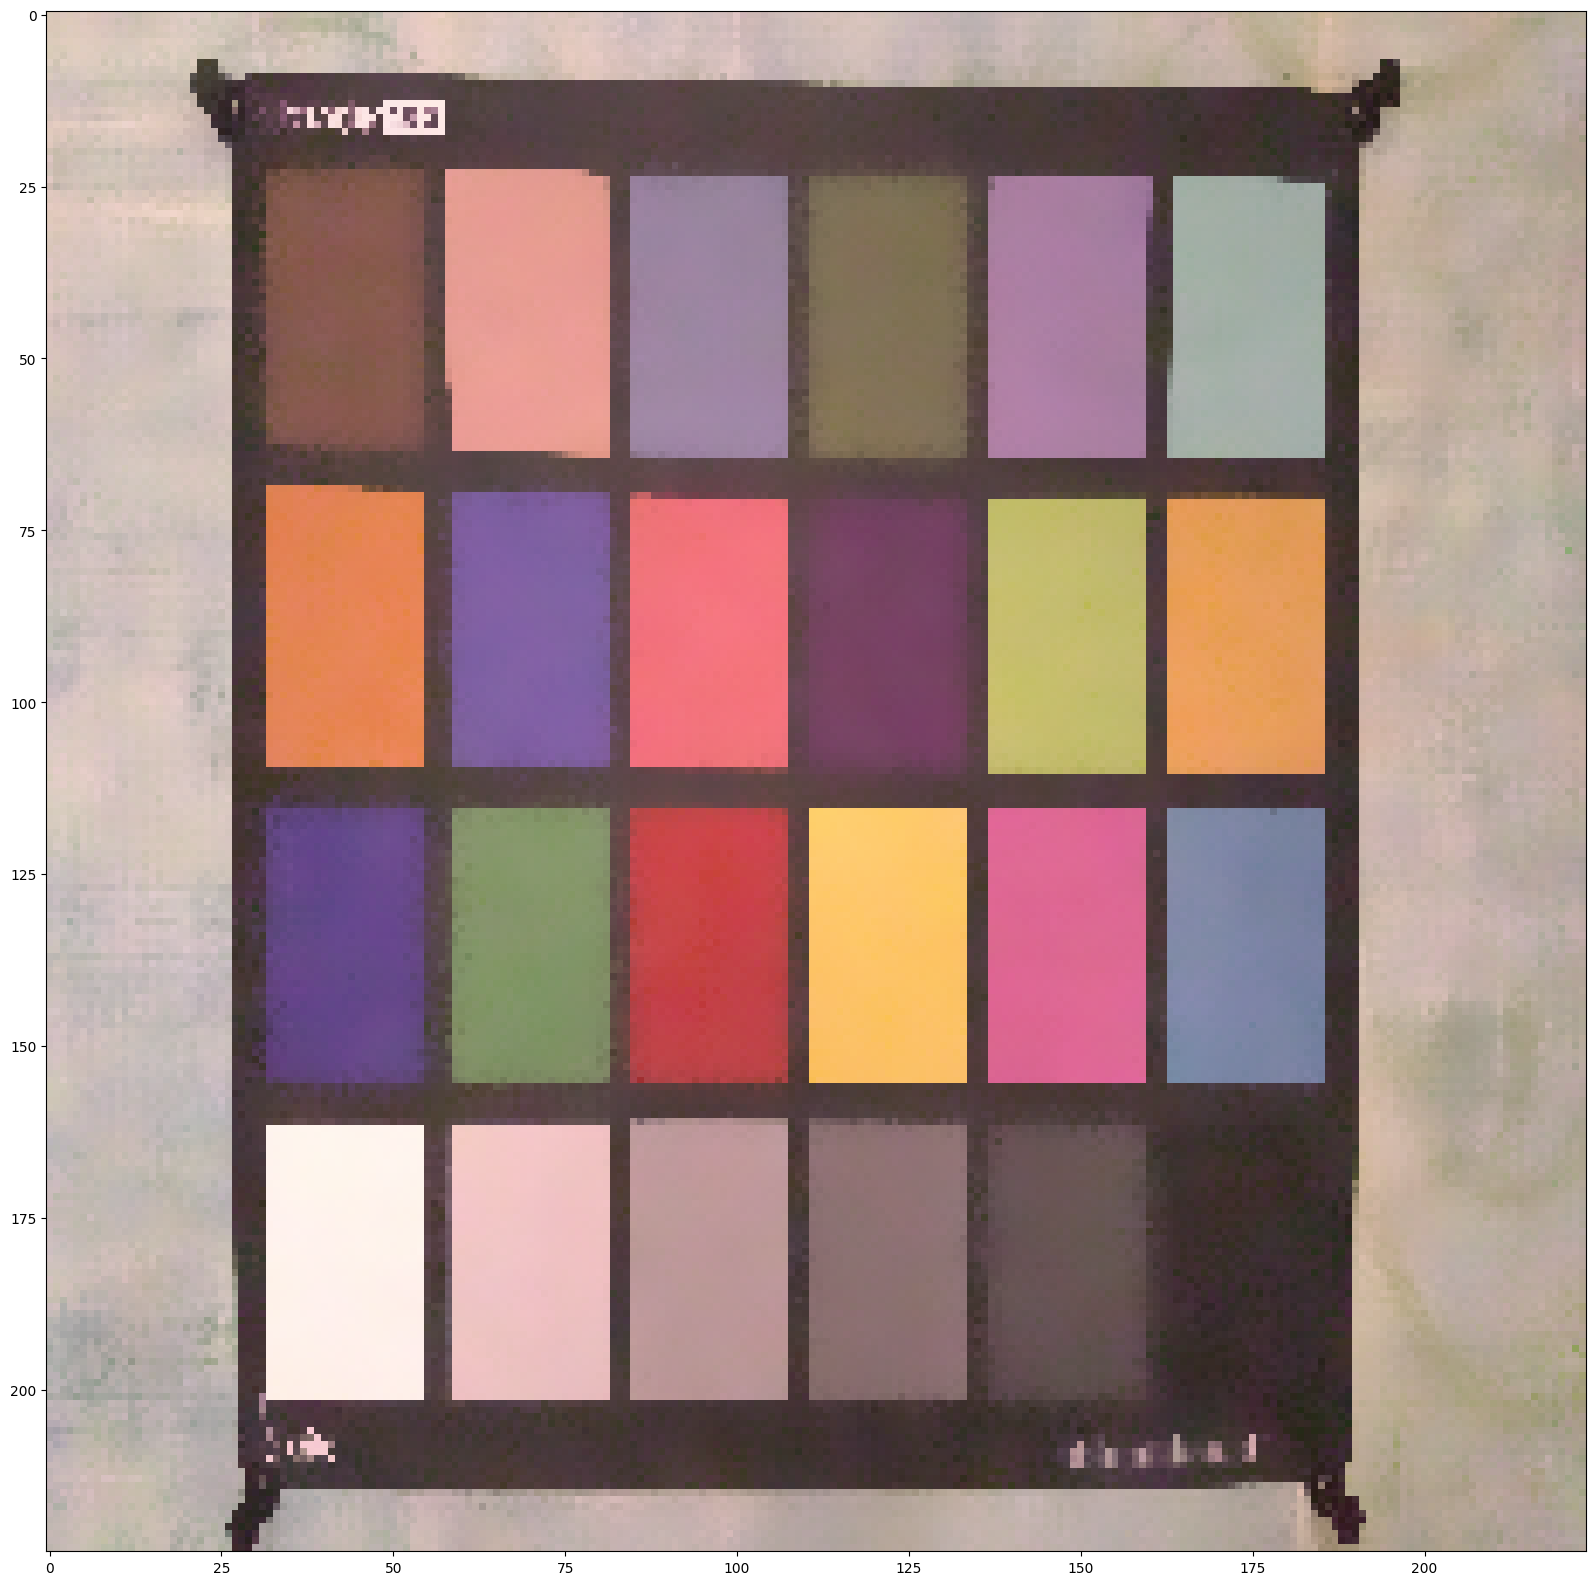

In [116]:
# apply bilateral filter with the parameters Diameter, SigmaColor, and SigmaSpace
bilateral_filtered = cv2.bilateralFilter(np.array(noisy_sample, dtype=np.float32), 9, 75, 75)

plt.figure(figsize=(20, 20))
plt.imshow(np.array(bilateral_filtered, dtype=np.int32))
plt.show()

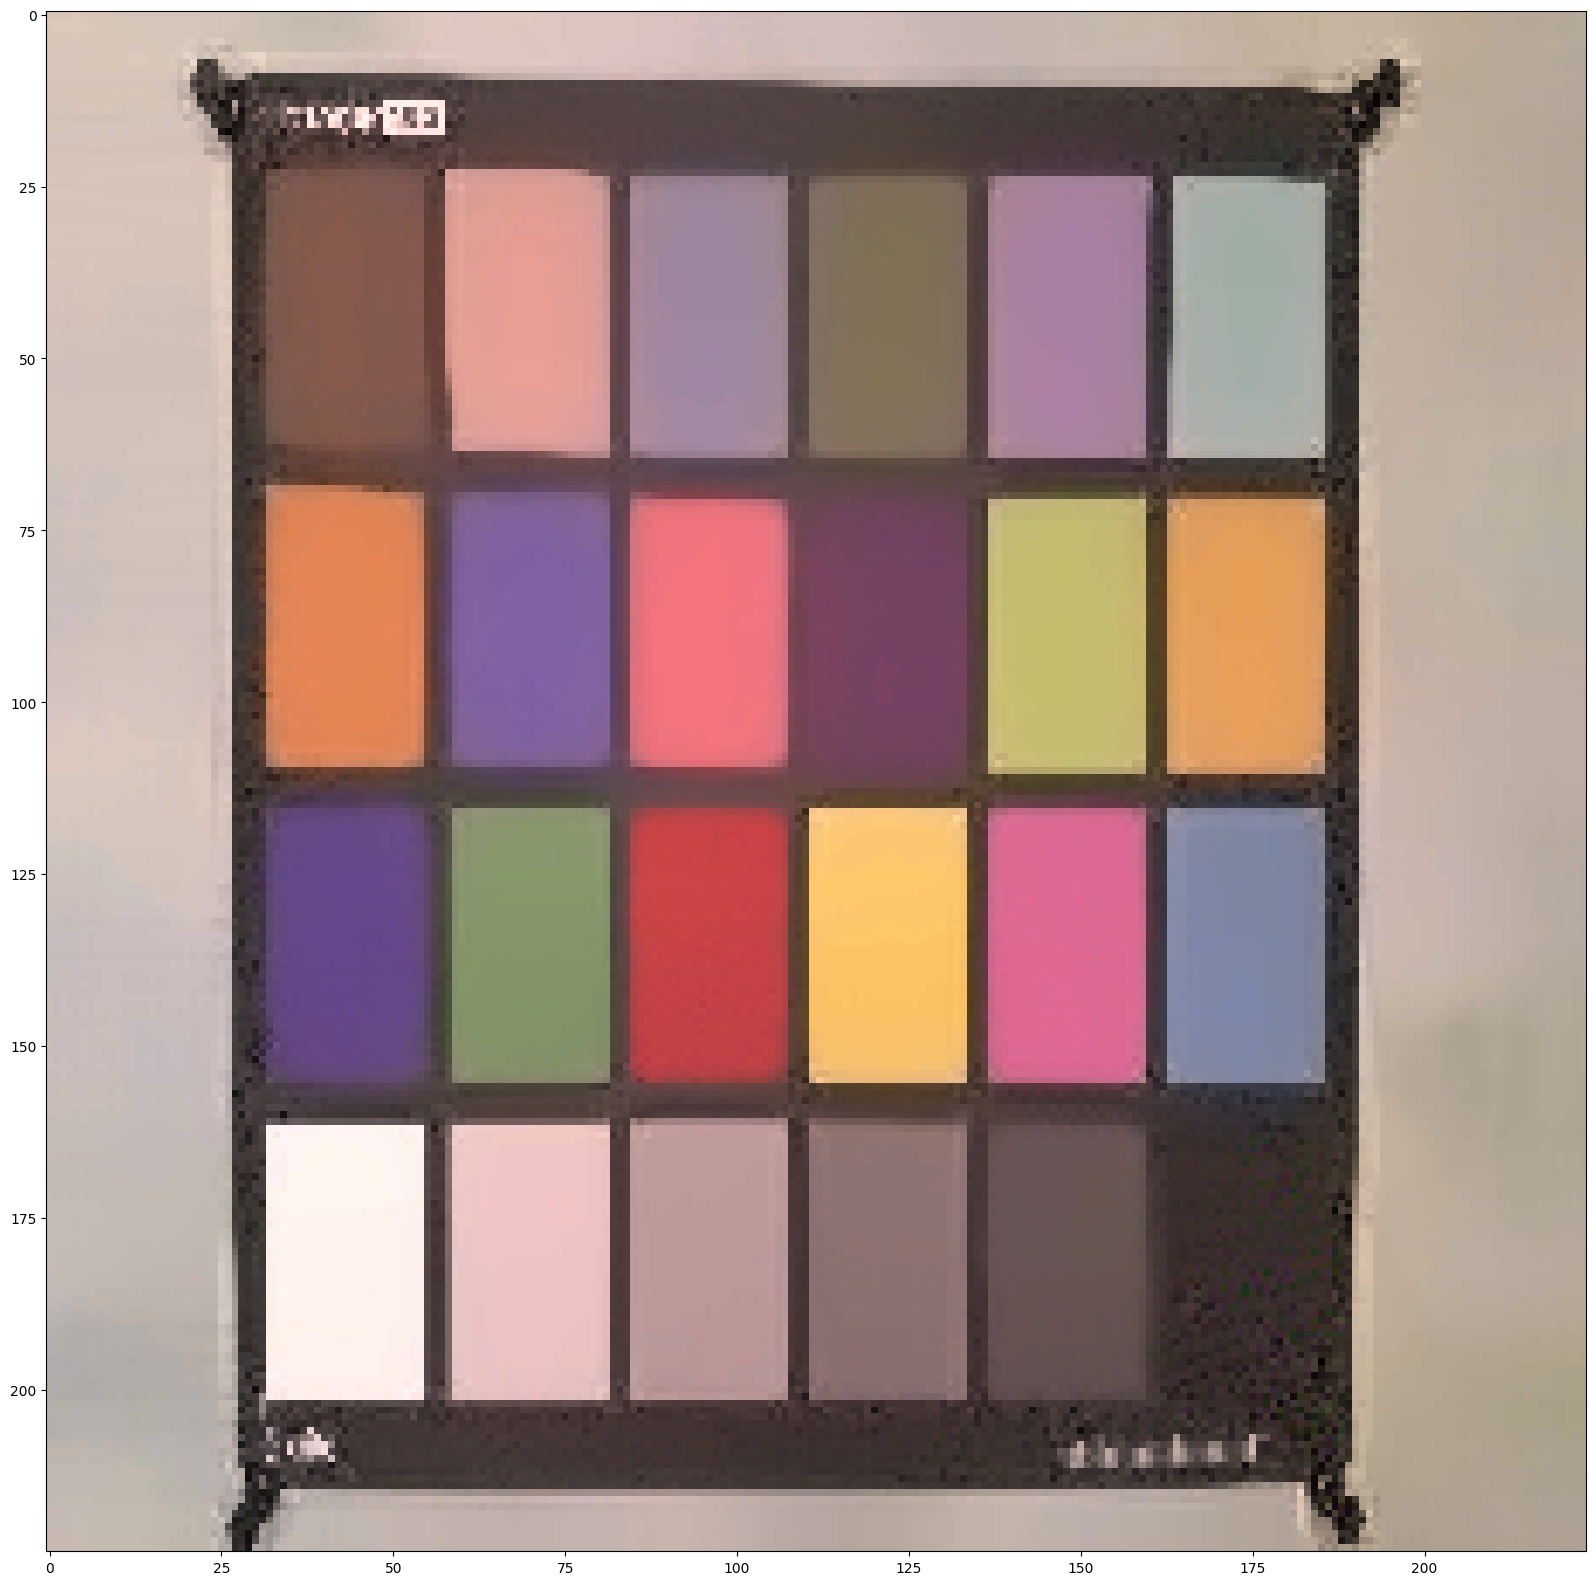

In [104]:
# apply Non-Local Means denoising with the parameters h, hForColorComponents, templateWindowSize, and searchWindowSize
nlm_filtered = cv2.fastNlMeansDenoisingColored(np.array(noisy_sample, dtype=np.uint8), None, 10, 10, 7, 21)

plt.figure(figsize=(20, 20))
plt.imshow(np.array(nlm_filtered, dtype=np.int32))
plt.show()

# Generate the GIF of results over time

In [50]:
# define gif name
gif_name = 'gan_results.gif'

# take list of paths for images
_, _, image_path_list = list(os.walk('/content', topdown=True))[0]

images = {}

for image in image_path_list:
    if image[:5] == "image":
        images[int(image.split('.')[0][-4:])] = image

# sort the image dictionary
sorted_keys = list(images.keys())
sorted_keys.sort()
images = {key:images[key] for key in sorted_keys}

# create a list of image objects
image_list = [Image.open(file) for file in list(images.values())]

# save the first image as a GIF file
image_list[0].save(gif_name,
                   save_all=True,
                   append_images=image_list[1:], # append rest of the images
                   duration=1000, # in milliseconds
                   loop=1)
